First I directly use the dataset from Udacity,  then I found there are only three label: car,truck,....But have no sky, no road,no others...  
Then I changed the dataset.

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import csv
import numpy as np
import cv2
import matplotlib.image as mpimg

import glob

#父目录中的.py文件
veh_images = glob.glob('vehicles/*/*.png')
print(len(veh_images))
not_veh_images = glob.glob('non-vehicles/*/*.png')
print(len(not_veh_images))


8792
8968


The vechiles and not_vechiles data set is nearly the same
The other problem I found later is that there are too many duplicate image, so I only use 10% of the image data set 

In [122]:
import random
car_set = random.sample(veh_images,int(len(veh_images)/6))
not_car_set = random.sample(not_veh_images,int(len(veh_images)/6))

print(len(car_set),len(not_car_set))


1465 1465


Display some images

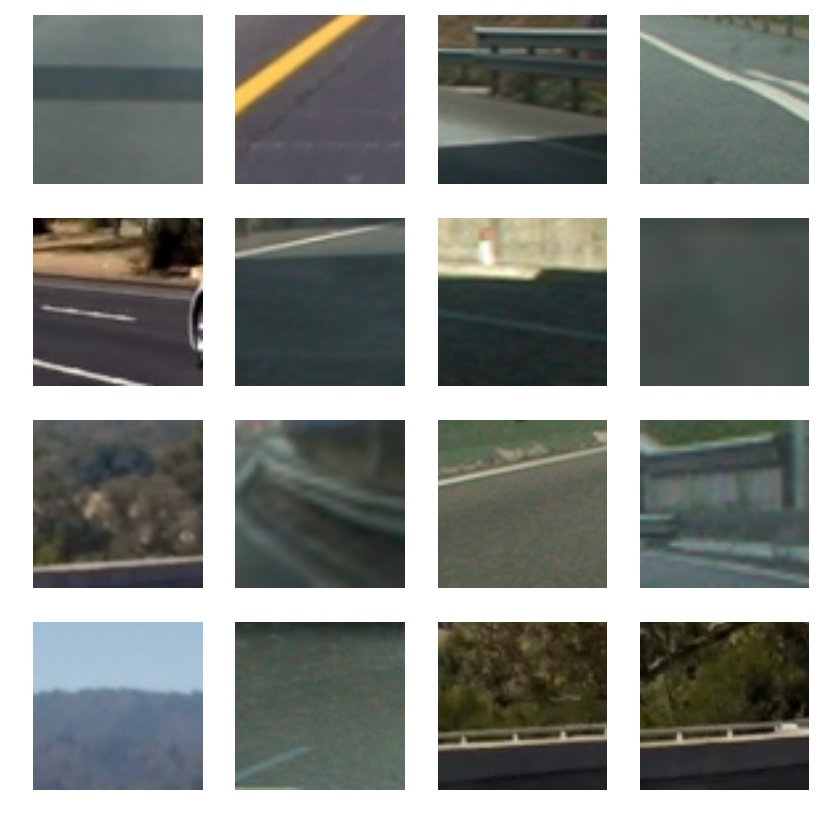

In [123]:
figure = plt.figure(figsize=(10,10))
factors = [4,4]
i = random.randint(0,900)
    
for ind in range(16):
    img = figure.add_subplot(factors[0],factors[1],ind + 1)
    val =  mpimg.imread(not_car_set[i+ind]) 
    plt.axis("off")
    plt.imshow(val, cmap='gray')

    

Now I have the car_set and not_car_set, both are 1099  
Next I will build the training set and labels set.   
there are 3 function , one is bin_spatial, the second is color hist, the third is get_hog_features, which will be trid in feature extra

In [124]:
from skimage.feature import hog

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector    
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
print('def func')

def func


Feature_extra, which combine the three above together

In [125]:
# Have this function call bin_spatial() and color_hist()
def extract_features(rows, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    i=0
    # Iterate through the list of images
    for row in rows:
        # Read in each one by one,then crop the image to the car
        
        image = mpimg.imread(row)       
        feature_image = cv2.resize(image, (64, 64)) 
        bin_features = bin_spatial(feature_image)
        color_features = color_hist(feature_image)
        
        
        # Call get_hog_features() with vis=False, feature_vec=True
        
        hog_features = []
        if hog_channel == 'ALL':            
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list                                    
        features.append(np.concatenate((bin_features,color_features,hog_features)))        
        #features.append(hog_features)

    # Return list of feature vectors
    return features

print('extra_function')


extra_function


we use extract_features build our train_set

In [126]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import svm 
from sklearn.metrics import accuracy_score

print('extra_features begin...')
sample=1000
car_features = extract_features(car_set, hog_channel='ALL')
not_car_features= extract_features(not_car_set, hog_channel='ALL')
print('extra_features end...')

 

extra_features begin...
extra_features end...


In [127]:
#train the set
def train_clf(car_features,not_car_features):
    if len(car_features) > 0:
        # Create an array stack of feature vectors
        X = np.vstack((car_features, not_car_features)).astype(np.float64)
        
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)

        y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))
        print('y',y.shape)

        scaled_X, y = shuffle(scaled_X, y)
                                
        # Split to train and test
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.1, random_state=rand_state)
        
        parameters = {'kernel':('linear','rbf'), 'C':[0.1,1,5, 10]}

        # TODO：initial classifier
        clf = svm.SVC()
        # Train the SVC
        grid_obj = GridSearchCV(clf,parameters)

        # TODO: Fit the grid search object to the training data and find the optimal parameters
        grid_obj = grid_obj.fit(X_train,y_train)

        # Get the estimator
        clf = grid_obj.best_estimator_    
        
        #clf = LinearSVC()
        #clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        print("Tuned model has a testing accuracy_score score of {:.4f}.".format(accuracy_score(y_test, y_pred)))
        return clf,X_scaler

clf,X_scaler = train_clf(car_features,not_car_features)  

y (2930,)
Tuned model has a testing accuracy_score score of 0.9932.


In [53]:
def validate_y(X_scale,clf,not_car_set):
    valid_not_car= extract_features(not_car_set[1000:1090], hog_channel='ALL')
    valid_car= extract_features(car_set[1000:1090], hog_channel='ALL')
    V_not = np.array(valid_not_car).astype(np.float64)
    V_car = np.array(valid_car).astype(np.float64)
    # Apply the scaler to X
    scaled_not = X_scaler.transform(V_not)
    scaled_car = X_scaler.transform(V_car)
    y = np.zeros(90)
    y_ped = clf.predict(scaled_not)    
    y_car = np.ones(90)
    y_ped_car = clf.predict(scaled_car)
    print('not car image accuracy',accuracy_score(y_ped,y))
    print('car image accuracy',accuracy_score(y_ped_car,y_car))

validate_y(X_scaler, clf,not_car_set)    

not car image accuracy 1.0
car image accuracy 0.955555555556


Search and classfiy

wind2 [((832, 392), (896, 456)), ((384, 424), (448, 488)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


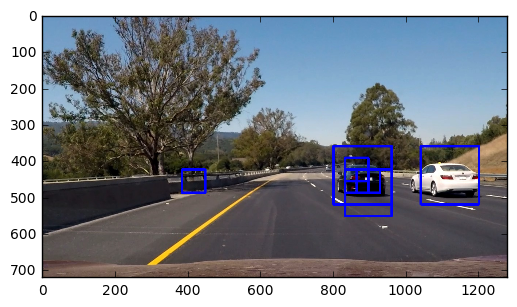

In [155]:
# Have this function call bin_spatial() and color_hist()
def single_img_features(feature_image, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
   
    bin_features = bin_spatial(feature_image)
    color_features = color_hist(feature_image)


    # Call get_hog_features() with vis=False, feature_vec=True
    hog_features = []
    if hog_channel == 'ALL':            
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
          
    # Return list of feature vectors
    return  np.concatenate((bin_features,color_features,hog_features))
    


# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, hog_channel='ALL',scale=2):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    img_features=[]
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64)) 
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img,hog_channel=hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
        #img_features.append(features)
    #8) Return windows for positive detections
    return on_windows

import types  

def all_muli2(windows):
    for elem in windows:
        if isinstance(elem,int): 
            elem*=2
        else:
            all_muli2(elem)
    return windows
       
    
def draw_vechile(image,debug=False,scale=2):
    ### TODO: Tweak these parameters and see how the results change.
    color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 0 # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 16    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [None, None] # Min and max in y to search in slide_window()

       
    draw_image = np.copy(image)
    #scale_high = int(draw_image.shape[1]/scale)
    #scale_width = int(draw_image.shape[0]/scale)
    #image = cv2.resize(image, (scale_high,scale_width))
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    windows=[]
    windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[int(image.shape[0]/2), int(image.shape[0]/2)+150], 
                        xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[int(image.shape[0]/2), int(image.shape[0]/2)+250], 
                        xy_window=(128, 128), xy_overlap=(0.5, 0.5))
    windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=[int(image.shape[0]/2), int(image.shape[0]/2)+250], 
                        xy_window=(160, 160), xy_overlap=(0.5, 0.5))
    #windows4 = slide_window(image, x_start_stop=[None, None], y_start_stop=[int(image.shape[0]/2), int(image.shape[0]/2)+250], 
                        #xy_window=(256, 256), xy_overlap=(0.5, 0.5))

    windows=windows1+windows2+windows3

    hot_windows = search_windows(image, windows, clf, X_scaler)   
   
    
    #img_features = X_scaler.transform(np.array(img_features).astype(np.float64))
    if debug==True:
        window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
        return window_img, hot_windows
    return hot_windows


window_img,hot_windows = draw_vechile(mpimg.imread('test_images/test6.jpg'),debug=True)
plt.imshow(window_img)
#print(clf.predict(img_features))

then use False Positives

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((768, 424), (832, 488)), ((832, 424), (896, 488)), ((832, 360), (960, 488)), ((720, 360), (880, 520)), ((800, 360), (960, 520))]


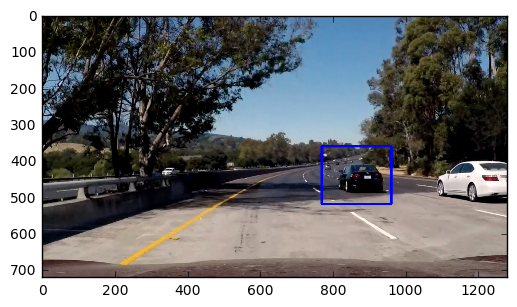

In [160]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def heat_map(image,debug=False):
    hot_windows = draw_vechile(image)
    # Read in image similar to one shown above 
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    if debug==True:
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(draw_img)
        plt.title('Car Positions')
        plt.subplot(122)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()
    return draw_img

#draw_img = heat_map(mpimg.imread('test_images/test1.jpg'))
plt.imshow(heat_map(mpimg.imread('test_images/test5.jpg')))


In [161]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


white_output = 'out_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(heat_map) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

wind2 []
[MoviePy] >>>> Building video out_video.mp4
[MoviePy] Writing video out_video.mp4


  0%|          | 1/1261 [00:02<56:35,  2.69s/it]

wind2 []


  0%|          | 2/1261 [00:05<58:03,  2.77s/it]

wind2 []


  0%|          | 3/1261 [00:08<58:46,  2.80s/it]

wind2 [((256, 360), (384, 488))]


  0%|          | 4/1261 [00:11<58:06,  2.77s/it]

wind2 []


  0%|          | 5/1261 [00:13<57:21,  2.74s/it]

wind2 [((256, 360), (384, 488))]


  0%|          | 6/1261 [00:16<56:55,  2.72s/it]

wind2 []


  1%|          | 7/1261 [00:19<56:36,  2.71s/it]

wind2 [((256, 360), (384, 488))]


  1%|          | 8/1261 [00:21<56:21,  2.70s/it]

wind2 [((256, 360), (384, 488))]


  1%|          | 9/1261 [00:24<55:59,  2.68s/it]

wind2 []


  1%|          | 10/1261 [00:27<55:51,  2.68s/it]

wind2 []


  1%|          | 11/1261 [00:29<55:39,  2.67s/it]

wind2 []


  1%|          | 12/1261 [00:32<55:36,  2.67s/it]

wind2 []


  1%|          | 13/1261 [00:35<55:26,  2.67s/it]

wind2 []


  1%|          | 14/1261 [00:37<55:29,  2.67s/it]

wind2 []


  1%|          | 15/1261 [00:40<55:20,  2.66s/it]

wind2 []


  1%|▏         | 16/1261 [00:43<55:19,  2.67s/it]

wind2 []


  1%|▏         | 17/1261 [00:45<55:14,  2.66s/it]

wind2 []


  1%|▏         | 18/1261 [00:48<55:06,  2.66s/it]

wind2 []


  2%|▏         | 19/1261 [00:51<55:06,  2.66s/it]

wind2 []


  2%|▏         | 20/1261 [00:53<54:53,  2.65s/it]

wind2 []


  2%|▏         | 21/1261 [00:56<54:43,  2.65s/it]

wind2 []


  2%|▏         | 22/1261 [00:59<54:39,  2.65s/it]

wind2 []


  2%|▏         | 23/1261 [01:01<54:33,  2.64s/it]

wind2 []


  2%|▏         | 24/1261 [01:04<54:42,  2.65s/it]

wind2 []


  2%|▏         | 25/1261 [01:07<54:44,  2.66s/it]

wind2 []


  2%|▏         | 26/1261 [01:09<54:43,  2.66s/it]

wind2 []


  2%|▏         | 27/1261 [01:12<54:33,  2.65s/it]

wind2 []


  2%|▏         | 28/1261 [01:15<54:29,  2.65s/it]

wind2 []


  2%|▏         | 29/1261 [01:17<54:25,  2.65s/it]

wind2 []


  2%|▏         | 30/1261 [01:20<54:17,  2.65s/it]

wind2 []


  2%|▏         | 31/1261 [01:22<54:16,  2.65s/it]

wind2 [((128, 424), (192, 488))]


  3%|▎         | 32/1261 [01:25<54:08,  2.64s/it]

wind2 []


  3%|▎         | 33/1261 [01:28<54:00,  2.64s/it]

wind2 []


  3%|▎         | 34/1261 [01:30<54:02,  2.64s/it]

wind2 []


  3%|▎         | 35/1261 [01:33<53:55,  2.64s/it]

wind2 []


  3%|▎         | 36/1261 [01:36<53:54,  2.64s/it]

wind2 []


  3%|▎         | 37/1261 [01:38<53:55,  2.64s/it]

wind2 []


  3%|▎         | 38/1261 [01:41<53:52,  2.64s/it]

wind2 [((1056, 392), (1120, 456)), ((256, 360), (384, 488))]


  3%|▎         | 39/1261 [01:44<53:39,  2.63s/it]

wind2 [((256, 360), (384, 488))]


  3%|▎         | 40/1261 [01:46<53:28,  2.63s/it]

wind2 [((1088, 392), (1152, 456)), ((256, 360), (384, 488))]


  3%|▎         | 41/1261 [01:49<53:16,  2.62s/it]

wind2 []


  3%|▎         | 42/1261 [01:51<53:18,  2.62s/it]

wind2 []


  3%|▎         | 43/1261 [01:54<53:12,  2.62s/it]

wind2 [((1120, 392), (1184, 456))]


  3%|▎         | 44/1261 [01:57<53:02,  2.61s/it]

wind2 []


  4%|▎         | 45/1261 [01:59<53:10,  2.62s/it]

wind2 [((1152, 392), (1216, 456))]


  4%|▎         | 46/1261 [02:02<52:57,  2.62s/it]

wind2 []


  4%|▎         | 47/1261 [02:04<52:55,  2.62s/it]

wind2 [((1184, 392), (1248, 456))]


  4%|▍         | 48/1261 [02:07<52:48,  2.61s/it]

wind2 []


  4%|▍         | 49/1261 [02:10<52:47,  2.61s/it]

wind2 []


  4%|▍         | 50/1261 [02:12<52:50,  2.62s/it]

wind2 []


  4%|▍         | 51/1261 [02:15<52:44,  2.62s/it]

wind2 []


  4%|▍         | 52/1261 [02:18<52:45,  2.62s/it]

wind2 []


  4%|▍         | 53/1261 [02:20<52:43,  2.62s/it]

wind2 []


  4%|▍         | 54/1261 [02:23<52:44,  2.62s/it]

wind2 []


  4%|▍         | 55/1261 [02:25<52:41,  2.62s/it]

wind2 []


  4%|▍         | 56/1261 [02:28<52:39,  2.62s/it]

wind2 []


  5%|▍         | 57/1261 [02:31<52:32,  2.62s/it]

wind2 []


  5%|▍         | 58/1261 [02:33<52:23,  2.61s/it]

wind2 []


  5%|▍         | 59/1261 [02:36<52:16,  2.61s/it]

wind2 []


  5%|▍         | 60/1261 [02:38<52:16,  2.61s/it]

wind2 []


  5%|▍         | 61/1261 [02:41<52:08,  2.61s/it]

wind2 []


  5%|▍         | 62/1261 [02:44<52:10,  2.61s/it]

wind2 []


  5%|▍         | 63/1261 [02:46<52:13,  2.62s/it]

wind2 []


  5%|▌         | 64/1261 [02:49<52:10,  2.62s/it]

wind2 []


  5%|▌         | 65/1261 [02:52<52:18,  2.62s/it]

wind2 []


  5%|▌         | 66/1261 [02:54<52:07,  2.62s/it]

wind2 []


  5%|▌         | 67/1261 [02:57<52:03,  2.62s/it]

wind2 []


  5%|▌         | 68/1261 [02:59<52:04,  2.62s/it]

wind2 []


  5%|▌         | 69/1261 [03:02<51:56,  2.61s/it]

wind2 []


  6%|▌         | 70/1261 [03:05<52:03,  2.62s/it]

wind2 []


  6%|▌         | 71/1261 [03:07<51:59,  2.62s/it]

wind2 []


  6%|▌         | 72/1261 [03:10<51:55,  2.62s/it]

wind2 []


  6%|▌         | 73/1261 [03:13<51:57,  2.62s/it]

wind2 []


  6%|▌         | 74/1261 [03:15<51:53,  2.62s/it]

wind2 []


  6%|▌         | 75/1261 [03:18<51:46,  2.62s/it]

wind2 []


  6%|▌         | 76/1261 [03:20<51:41,  2.62s/it]

wind2 []


  6%|▌         | 77/1261 [03:23<51:44,  2.62s/it]

wind2 []


  6%|▌         | 78/1261 [03:26<51:30,  2.61s/it]

wind2 [((128, 424), (192, 488))]


  6%|▋         | 79/1261 [03:28<51:31,  2.62s/it]

wind2 []


  6%|▋         | 80/1261 [03:31<51:29,  2.62s/it]

wind2 []


  6%|▋         | 81/1261 [03:33<51:35,  2.62s/it]

wind2 []


  7%|▋         | 82/1261 [03:36<51:23,  2.62s/it]

wind2 []


  7%|▋         | 83/1261 [03:39<51:22,  2.62s/it]

wind2 []


  7%|▋         | 84/1261 [03:41<51:23,  2.62s/it]

wind2 []


  7%|▋         | 85/1261 [03:44<51:17,  2.62s/it]

wind2 [((256, 360), (384, 488))]


  7%|▋         | 86/1261 [03:47<51:06,  2.61s/it]

wind2 []


  7%|▋         | 87/1261 [03:49<51:01,  2.61s/it]

wind2 []


  7%|▋         | 88/1261 [03:52<51:11,  2.62s/it]

wind2 []


  7%|▋         | 89/1261 [03:54<51:01,  2.61s/it]

wind2 []


  7%|▋         | 90/1261 [03:57<50:56,  2.61s/it]

wind2 []


  7%|▋         | 91/1261 [04:00<50:59,  2.61s/it]

wind2 []


  7%|▋         | 92/1261 [04:02<50:52,  2.61s/it]

wind2 []


  7%|▋         | 93/1261 [04:05<50:55,  2.62s/it]

wind2 []


  7%|▋         | 94/1261 [04:07<50:51,  2.61s/it]

wind2 []


  8%|▊         | 95/1261 [04:10<50:45,  2.61s/it]

wind2 []


  8%|▊         | 96/1261 [04:13<50:40,  2.61s/it]

wind2 []


  8%|▊         | 97/1261 [04:15<50:45,  2.62s/it]

wind2 []


  8%|▊         | 98/1261 [04:18<50:44,  2.62s/it]

wind2 []


  8%|▊         | 99/1261 [04:21<50:35,  2.61s/it]

wind2 []


  8%|▊         | 100/1261 [04:23<50:32,  2.61s/it]

wind2 [((256, 360), (384, 488))]


  8%|▊         | 101/1261 [04:26<50:26,  2.61s/it]

wind2 []


  8%|▊         | 102/1261 [04:28<50:19,  2.60s/it]

wind2 []


  8%|▊         | 103/1261 [04:31<50:20,  2.61s/it]

wind2 []


  8%|▊         | 104/1261 [04:34<50:16,  2.61s/it]

wind2 []


  8%|▊         | 105/1261 [04:36<50:18,  2.61s/it]

wind2 []


  8%|▊         | 106/1261 [04:39<50:12,  2.61s/it]

wind2 []


  8%|▊         | 107/1261 [04:41<50:09,  2.61s/it]

wind2 []


  9%|▊         | 108/1261 [04:44<50:11,  2.61s/it]

wind2 []


  9%|▊         | 109/1261 [04:47<50:09,  2.61s/it]

wind2 []


  9%|▊         | 110/1261 [04:49<50:04,  2.61s/it]

wind2 [((160, 392), (224, 456)), ((160, 424), (224, 488))]


  9%|▉         | 111/1261 [04:52<50:10,  2.62s/it]

wind2 []


  9%|▉         | 112/1261 [04:54<50:17,  2.63s/it]

wind2 []


  9%|▉         | 113/1261 [04:57<50:12,  2.62s/it]

wind2 [((160, 424), (224, 488))]


  9%|▉         | 114/1261 [05:00<50:08,  2.62s/it]

wind2 []


  9%|▉         | 115/1261 [05:02<50:01,  2.62s/it]

wind2 []


  9%|▉         | 116/1261 [05:05<50:03,  2.62s/it]

wind2 []


  9%|▉         | 117/1261 [05:08<50:02,  2.62s/it]

wind2 [((32, 392), (96, 456))]


  9%|▉         | 118/1261 [05:10<49:58,  2.62s/it]

wind2 []


  9%|▉         | 119/1261 [05:13<49:48,  2.62s/it]

wind2 []


 10%|▉         | 120/1261 [05:15<49:47,  2.62s/it]

wind2 []


 10%|▉         | 121/1261 [05:18<50:20,  2.65s/it]

wind2 []


 10%|▉         | 122/1261 [05:21<50:15,  2.65s/it]

wind2 []


 10%|▉         | 123/1261 [05:23<50:04,  2.64s/it]

wind2 []


 10%|▉         | 124/1261 [05:26<50:05,  2.64s/it]

wind2 [((64, 424), (128, 488))]


 10%|▉         | 125/1261 [05:29<49:57,  2.64s/it]

wind2 []


 10%|▉         | 126/1261 [05:31<49:47,  2.63s/it]

wind2 []


 10%|█         | 127/1261 [05:34<49:43,  2.63s/it]

wind2 []


 10%|█         | 128/1261 [05:37<49:39,  2.63s/it]

wind2 []


 10%|█         | 129/1261 [05:39<49:40,  2.63s/it]

wind2 []


 10%|█         | 130/1261 [05:42<49:38,  2.63s/it]

wind2 []


 10%|█         | 131/1261 [05:44<49:31,  2.63s/it]

wind2 []


 10%|█         | 132/1261 [05:47<49:27,  2.63s/it]

wind2 []


 11%|█         | 133/1261 [05:50<49:29,  2.63s/it]

wind2 []


 11%|█         | 134/1261 [05:52<49:38,  2.64s/it]

wind2 []


 11%|█         | 135/1261 [05:55<49:47,  2.65s/it]

wind2 [((224, 424), (288, 488))]


 11%|█         | 136/1261 [05:58<49:36,  2.65s/it]

wind2 [((224, 424), (288, 488))]


 11%|█         | 137/1261 [06:00<49:29,  2.64s/it]

wind2 []


 11%|█         | 138/1261 [06:03<49:25,  2.64s/it]

wind2 []


 11%|█         | 139/1261 [06:06<49:24,  2.64s/it]

wind2 []


 11%|█         | 140/1261 [06:08<49:18,  2.64s/it]

wind2 []


 11%|█         | 141/1261 [06:11<49:11,  2.64s/it]

wind2 []


 11%|█▏        | 142/1261 [06:14<49:02,  2.63s/it]

wind2 []


 11%|█▏        | 143/1261 [06:16<49:01,  2.63s/it]

wind2 []


 11%|█▏        | 144/1261 [06:19<48:49,  2.62s/it]

wind2 []


 11%|█▏        | 145/1261 [06:21<48:49,  2.63s/it]

wind2 []


 12%|█▏        | 146/1261 [06:24<48:42,  2.62s/it]

wind2 []


 12%|█▏        | 147/1261 [06:27<48:41,  2.62s/it]

wind2 []


 12%|█▏        | 148/1261 [06:29<48:40,  2.62s/it]

wind2 []


 12%|█▏        | 149/1261 [06:32<48:37,  2.62s/it]

wind2 []


 12%|█▏        | 150/1261 [06:34<48:31,  2.62s/it]

wind2 []


 12%|█▏        | 151/1261 [06:37<48:31,  2.62s/it]

wind2 [((1152, 424), (1280, 552))]


 12%|█▏        | 152/1261 [06:40<48:22,  2.62s/it]

wind2 [((1152, 424), (1280, 552))]


 12%|█▏        | 153/1261 [06:42<48:16,  2.61s/it]

wind2 [((1152, 424), (1280, 552))]


 12%|█▏        | 154/1261 [06:45<48:15,  2.62s/it]

wind2 [((1152, 424), (1280, 552))]


 12%|█▏        | 155/1261 [06:48<48:10,  2.61s/it]

wind2 [((1152, 424), (1280, 552))]


 12%|█▏        | 156/1261 [06:50<48:06,  2.61s/it]

wind2 []


 12%|█▏        | 157/1261 [06:53<48:09,  2.62s/it]

wind2 []


 13%|█▎        | 158/1261 [06:55<48:23,  2.63s/it]

wind2 [((1152, 424), (1280, 552))]


 13%|█▎        | 159/1261 [06:58<48:14,  2.63s/it]

wind2 [((1152, 424), (1280, 552))]


 13%|█▎        | 160/1261 [07:01<48:11,  2.63s/it]

wind2 [((1152, 424), (1280, 552))]


 13%|█▎        | 161/1261 [07:03<48:03,  2.62s/it]

wind2 [((1152, 424), (1280, 552))]


 13%|█▎        | 162/1261 [07:06<47:53,  2.61s/it]

wind2 [((1152, 424), (1280, 552))]


 13%|█▎        | 163/1261 [07:09<47:50,  2.61s/it]

wind2 [((1152, 424), (1280, 552))]


 13%|█▎        | 164/1261 [07:11<47:41,  2.61s/it]

wind2 [((1152, 424), (1280, 552))]


 13%|█▎        | 165/1261 [07:14<47:49,  2.62s/it]

wind2 []


 13%|█▎        | 166/1261 [07:16<47:42,  2.61s/it]

wind2 []


 13%|█▎        | 167/1261 [07:19<47:40,  2.61s/it]

wind2 []


 13%|█▎        | 168/1261 [07:22<47:40,  2.62s/it]

wind2 []


 13%|█▎        | 169/1261 [07:24<47:39,  2.62s/it]

wind2 []


 13%|█▎        | 170/1261 [07:27<47:33,  2.62s/it]

wind2 []


 14%|█▎        | 171/1261 [07:29<47:34,  2.62s/it]

wind2 []


 14%|█▎        | 172/1261 [07:32<47:37,  2.62s/it]

wind2 []


 14%|█▎        | 173/1261 [07:35<47:38,  2.63s/it]

wind2 []


 14%|█▍        | 174/1261 [07:37<47:37,  2.63s/it]

wind2 []


 14%|█▍        | 175/1261 [07:40<47:23,  2.62s/it]

wind2 []


 14%|█▍        | 176/1261 [07:43<47:25,  2.62s/it]

wind2 []


 14%|█▍        | 177/1261 [07:45<47:11,  2.61s/it]

wind2 []


 14%|█▍        | 178/1261 [07:48<47:05,  2.61s/it]

wind2 [((64, 392), (128, 456))]


 14%|█▍        | 179/1261 [07:50<46:58,  2.61s/it]

wind2 []


 14%|█▍        | 180/1261 [07:53<47:02,  2.61s/it]

wind2 []


 14%|█▍        | 181/1261 [07:56<47:18,  2.63s/it]

wind2 []


 14%|█▍        | 182/1261 [07:58<47:13,  2.63s/it]

wind2 [((32, 392), (96, 456))]


 15%|█▍        | 183/1261 [08:01<47:05,  2.62s/it]

wind2 []


 15%|█▍        | 184/1261 [08:04<47:04,  2.62s/it]

wind2 [((1088, 424), (1216, 552))]


 15%|█▍        | 185/1261 [08:06<47:04,  2.62s/it]

wind2 [((1088, 424), (1216, 552))]


 15%|█▍        | 186/1261 [08:09<47:04,  2.63s/it]

wind2 [((0, 392), (64, 456)), ((1088, 424), (1216, 552))]


 15%|█▍        | 187/1261 [08:11<47:04,  2.63s/it]

wind2 [((1088, 424), (1216, 552))]


 15%|█▍        | 188/1261 [08:14<46:59,  2.63s/it]

wind2 [((1088, 424), (1216, 552))]


 15%|█▍        | 189/1261 [08:17<46:53,  2.62s/it]

wind2 [((1088, 424), (1216, 552))]


 15%|█▌        | 190/1261 [08:19<46:53,  2.63s/it]

wind2 []


 15%|█▌        | 191/1261 [08:22<46:50,  2.63s/it]

wind2 []


 15%|█▌        | 192/1261 [08:25<46:48,  2.63s/it]

wind2 []


 15%|█▌        | 193/1261 [08:27<46:39,  2.62s/it]

wind2 []


 15%|█▌        | 194/1261 [08:30<46:36,  2.62s/it]

wind2 []


 15%|█▌        | 195/1261 [08:32<46:30,  2.62s/it]

wind2 []


 16%|█▌        | 196/1261 [08:35<46:26,  2.62s/it]

wind2 []


 16%|█▌        | 197/1261 [08:38<46:19,  2.61s/it]

wind2 []


 16%|█▌        | 198/1261 [08:40<46:15,  2.61s/it]

wind2 []


 16%|█▌        | 199/1261 [08:43<46:18,  2.62s/it]

wind2 []


 16%|█▌        | 200/1261 [08:45<46:07,  2.61s/it]

wind2 []


 16%|█▌        | 201/1261 [08:48<46:07,  2.61s/it]

wind2 []


 16%|█▌        | 202/1261 [08:51<46:03,  2.61s/it]

wind2 []


 16%|█▌        | 203/1261 [08:53<46:05,  2.61s/it]

wind2 []


 16%|█▌        | 204/1261 [08:56<46:13,  2.62s/it]

wind2 []


 16%|█▋        | 205/1261 [08:59<46:05,  2.62s/it]

wind2 []


 16%|█▋        | 206/1261 [09:01<46:03,  2.62s/it]

wind2 []


 16%|█▋        | 207/1261 [09:04<45:55,  2.61s/it]

wind2 []


 16%|█▋        | 208/1261 [09:06<45:56,  2.62s/it]

wind2 [((1152, 424), (1280, 552))]


 17%|█▋        | 209/1261 [09:09<45:55,  2.62s/it]

wind2 [((1152, 424), (1280, 552))]


 17%|█▋        | 210/1261 [09:12<45:45,  2.61s/it]

wind2 []


 17%|█▋        | 211/1261 [09:14<45:44,  2.61s/it]

wind2 []


 17%|█▋        | 212/1261 [09:17<45:43,  2.62s/it]

wind2 []


 17%|█▋        | 213/1261 [09:19<45:46,  2.62s/it]

wind2 []


 17%|█▋        | 214/1261 [09:22<45:44,  2.62s/it]

wind2 []


 17%|█▋        | 215/1261 [09:25<45:39,  2.62s/it]

wind2 []


 17%|█▋        | 216/1261 [09:27<45:36,  2.62s/it]

wind2 []


 17%|█▋        | 217/1261 [09:30<45:31,  2.62s/it]

wind2 []


 17%|█▋        | 218/1261 [09:33<45:25,  2.61s/it]

wind2 []


 17%|█▋        | 219/1261 [09:35<45:23,  2.61s/it]

wind2 []


 17%|█▋        | 220/1261 [09:38<45:36,  2.63s/it]

wind2 []


 18%|█▊        | 221/1261 [09:40<45:23,  2.62s/it]

wind2 []


 18%|█▊        | 222/1261 [09:43<45:25,  2.62s/it]

wind2 []


 18%|█▊        | 223/1261 [09:46<45:17,  2.62s/it]

wind2 []


 18%|█▊        | 224/1261 [09:48<45:19,  2.62s/it]

wind2 []


 18%|█▊        | 225/1261 [09:51<45:23,  2.63s/it]

wind2 []


 18%|█▊        | 226/1261 [09:54<45:21,  2.63s/it]

wind2 []


 18%|█▊        | 227/1261 [09:56<45:18,  2.63s/it]

wind2 [((160, 424), (224, 488))]


 18%|█▊        | 228/1261 [09:59<45:12,  2.63s/it]

wind2 [((128, 424), (192, 488))]


 18%|█▊        | 229/1261 [10:01<45:05,  2.62s/it]

wind2 [((96, 424), (160, 488))]


 18%|█▊        | 230/1261 [10:04<45:03,  2.62s/it]

wind2 [((64, 424), (128, 488))]


 18%|█▊        | 231/1261 [10:07<45:06,  2.63s/it]

wind2 [((32, 424), (96, 488))]


 18%|█▊        | 232/1261 [10:09<44:55,  2.62s/it]

wind2 []


 18%|█▊        | 233/1261 [10:12<44:50,  2.62s/it]

wind2 []


 19%|█▊        | 234/1261 [10:15<44:54,  2.62s/it]

wind2 []


 19%|█▊        | 235/1261 [10:17<45:22,  2.65s/it]

wind2 []


 19%|█▊        | 236/1261 [10:20<45:18,  2.65s/it]

wind2 []


 19%|█▉        | 237/1261 [10:23<45:09,  2.65s/it]

wind2 []


 19%|█▉        | 238/1261 [10:25<45:02,  2.64s/it]

wind2 []


 19%|█▉        | 239/1261 [10:28<45:00,  2.64s/it]

wind2 [((96, 424), (160, 488)), ((1120, 360), (1280, 520))]


 19%|█▉        | 240/1261 [10:30<44:56,  2.64s/it]

wind2 [((96, 424), (160, 488)), ((1120, 360), (1280, 520))]


 19%|█▉        | 241/1261 [10:33<44:56,  2.64s/it]

wind2 [((64, 424), (128, 488)), ((1120, 360), (1280, 520))]


 19%|█▉        | 242/1261 [10:36<44:45,  2.64s/it]

wind2 [((32, 424), (96, 488)), ((160, 424), (224, 488)), ((1120, 360), (1280, 520))]


 19%|█▉        | 243/1261 [10:38<44:44,  2.64s/it]

wind2 [((768, 392), (832, 456)), ((0, 424), (64, 488)), ((160, 424), (224, 488)), ((1120, 360), (1280, 520))]


 19%|█▉        | 244/1261 [10:41<44:46,  2.64s/it]

wind2 [((128, 424), (192, 488)), ((1120, 360), (1280, 520))]


 19%|█▉        | 245/1261 [10:44<44:42,  2.64s/it]

wind2 [((96, 392), (160, 456)), ((96, 424), (160, 488)), ((128, 424), (192, 488)), ((1120, 360), (1280, 520))]


 20%|█▉        | 246/1261 [10:46<44:43,  2.64s/it]

wind2 [((64, 424), (128, 488)), ((96, 424), (160, 488)), ((1152, 424), (1280, 552)), ((1120, 360), (1280, 520))]


 20%|█▉        | 247/1261 [10:49<44:39,  2.64s/it]

wind2 [((0, 424), (64, 488)), ((64, 424), (128, 488)), ((128, 424), (192, 488)), ((1120, 360), (1280, 520))]


 20%|█▉        | 248/1261 [10:52<44:33,  2.64s/it]

wind2 [((96, 424), (160, 488)), ((1120, 360), (1280, 520))]


 20%|█▉        | 249/1261 [10:54<44:29,  2.64s/it]

wind2 [((1120, 360), (1280, 520))]


 20%|█▉        | 250/1261 [10:57<44:38,  2.65s/it]

wind2 [((1152, 424), (1280, 552)), ((1120, 360), (1280, 520))]


 20%|█▉        | 251/1261 [11:00<44:27,  2.64s/it]

wind2 [((1120, 360), (1280, 520))]


 20%|█▉        | 252/1261 [11:02<44:20,  2.64s/it]

wind2 [((1120, 360), (1280, 520))]


 20%|██        | 253/1261 [11:05<44:18,  2.64s/it]

wind2 [((800, 392), (864, 456)), ((1120, 360), (1280, 520)), ((560, 440), (720, 600))]


 20%|██        | 254/1261 [11:07<44:14,  2.64s/it]

wind2 [((1120, 360), (1280, 520)), ((560, 440), (720, 600))]


 20%|██        | 255/1261 [11:10<45:01,  2.69s/it]

wind2 [((1120, 360), (1280, 520))]


 20%|██        | 256/1261 [11:13<46:03,  2.75s/it]

wind2 [((1120, 360), (1280, 520))]


 20%|██        | 257/1261 [11:16<45:52,  2.74s/it]

wind2 [((1152, 424), (1280, 552)), ((1120, 360), (1280, 520))]


 20%|██        | 258/1261 [11:19<45:40,  2.73s/it]

wind2 [((1152, 424), (1280, 552)), ((1120, 360), (1280, 520))]


 21%|██        | 259/1261 [11:21<45:51,  2.75s/it]

wind2 [((1152, 424), (1280, 552)), ((1120, 360), (1280, 520))]


 21%|██        | 260/1261 [11:24<45:29,  2.73s/it]

wind2 [((832, 392), (896, 456)), ((1184, 424), (1248, 488)), ((1152, 424), (1280, 552)), ((1120, 360), (1280, 520)), ((560, 440), (720, 600))]


 21%|██        | 261/1261 [11:27<45:23,  2.72s/it]

wind2 [((832, 392), (896, 456)), ((1152, 424), (1280, 552)), ((1120, 360), (1280, 520))]


 21%|██        | 262/1261 [11:30<47:11,  2.83s/it]

wind2 [((1152, 424), (1280, 552)), ((1120, 360), (1280, 520))]


 21%|██        | 263/1261 [11:33<48:32,  2.92s/it]

wind2 [((1152, 424), (1280, 552)), ((1120, 360), (1280, 520))]


 21%|██        | 264/1261 [11:36<47:22,  2.85s/it]

wind2 [((1152, 424), (1280, 552)), ((1120, 360), (1280, 520))]


 21%|██        | 265/1261 [11:38<47:23,  2.86s/it]

wind2 [((1152, 424), (1280, 552)), ((1120, 360), (1280, 520))]


 21%|██        | 266/1261 [11:41<46:15,  2.79s/it]

wind2 [((1120, 360), (1280, 520))]


 21%|██        | 267/1261 [11:44<45:23,  2.74s/it]

wind2 [((1152, 424), (1280, 552)), ((1120, 360), (1280, 520))]


 21%|██▏       | 268/1261 [11:46<44:49,  2.71s/it]

wind2 [((1152, 424), (1280, 552)), ((1120, 360), (1280, 520))]


 21%|██▏       | 269/1261 [11:49<44:28,  2.69s/it]

wind2 [((1152, 424), (1280, 552)), ((1120, 360), (1280, 520))]


 21%|██▏       | 270/1261 [11:52<44:09,  2.67s/it]

wind2 [((1152, 424), (1280, 552)), ((1120, 360), (1280, 520))]


 21%|██▏       | 271/1261 [11:54<43:53,  2.66s/it]

wind2 [((128, 424), (192, 488)), ((1152, 424), (1280, 552)), ((1120, 360), (1280, 520))]


 22%|██▏       | 272/1261 [11:57<43:44,  2.65s/it]

wind2 [((1120, 360), (1280, 520))]


 22%|██▏       | 273/1261 [12:00<43:30,  2.64s/it]

wind2 [((64, 424), (128, 488)), ((1120, 360), (1280, 520))]


 22%|██▏       | 274/1261 [12:02<43:19,  2.63s/it]

wind2 [((1120, 360), (1280, 520))]


 22%|██▏       | 275/1261 [12:05<43:13,  2.63s/it]

wind2 [((96, 360), (160, 424)), ((1120, 360), (1280, 520))]


 22%|██▏       | 276/1261 [12:07<43:06,  2.63s/it]

wind2 [((96, 360), (160, 424)), ((1120, 360), (1280, 520))]


 22%|██▏       | 277/1261 [12:10<42:59,  2.62s/it]

wind2 [((224, 424), (288, 488))]


 22%|██▏       | 278/1261 [12:13<42:56,  2.62s/it]

wind2 []


 22%|██▏       | 279/1261 [12:15<42:54,  2.62s/it]

wind2 [((224, 424), (288, 488))]


 22%|██▏       | 280/1261 [12:18<42:47,  2.62s/it]

wind2 [((224, 424), (288, 488))]


 22%|██▏       | 281/1261 [12:20<42:52,  2.62s/it]

wind2 [((224, 424), (288, 488))]


 22%|██▏       | 282/1261 [12:23<42:53,  2.63s/it]

wind2 []


 22%|██▏       | 283/1261 [12:26<42:48,  2.63s/it]

wind2 [((1040, 360), (1200, 520))]


 23%|██▎       | 284/1261 [12:28<42:51,  2.63s/it]

wind2 [((1040, 360), (1200, 520))]


 23%|██▎       | 285/1261 [12:31<42:41,  2.62s/it]

wind2 []


 23%|██▎       | 286/1261 [12:34<42:36,  2.62s/it]

wind2 [((1040, 360), (1200, 520))]


 23%|██▎       | 287/1261 [12:36<42:28,  2.62s/it]

wind2 [((1040, 360), (1200, 520))]


 23%|██▎       | 288/1261 [12:39<42:23,  2.61s/it]

wind2 [((1040, 360), (1200, 520))]


 23%|██▎       | 289/1261 [12:41<42:23,  2.62s/it]

wind2 [((1040, 360), (1200, 520))]


 23%|██▎       | 290/1261 [12:44<42:19,  2.62s/it]

wind2 [((1040, 360), (1200, 520))]


 23%|██▎       | 291/1261 [12:47<42:18,  2.62s/it]

wind2 [((32, 424), (96, 488)), ((1040, 360), (1200, 520))]


 23%|██▎       | 292/1261 [12:49<42:17,  2.62s/it]

wind2 [((0, 424), (64, 488)), ((1040, 360), (1200, 520))]


 23%|██▎       | 293/1261 [12:52<42:15,  2.62s/it]

wind2 [((960, 424), (1024, 488)), ((1040, 360), (1200, 520))]


 23%|██▎       | 294/1261 [12:55<42:19,  2.63s/it]

wind2 [((1040, 360), (1200, 520))]


 23%|██▎       | 295/1261 [12:57<42:27,  2.64s/it]

wind2 [((1088, 424), (1216, 552)), ((1040, 360), (1200, 520))]


 23%|██▎       | 296/1261 [13:00<42:17,  2.63s/it]

wind2 [((960, 424), (1024, 488)), ((1040, 360), (1200, 520))]


 24%|██▎       | 297/1261 [13:02<42:13,  2.63s/it]

wind2 [((896, 392), (960, 456)), ((224, 424), (288, 488)), ((960, 424), (1024, 488)), ((1040, 360), (1200, 520))]


 24%|██▎       | 298/1261 [13:05<42:10,  2.63s/it]

wind2 [((1088, 424), (1216, 552)), ((1040, 360), (1200, 520))]


 24%|██▎       | 299/1261 [13:08<42:06,  2.63s/it]

wind2 [((1040, 360), (1200, 520))]


 24%|██▍       | 300/1261 [13:10<42:03,  2.63s/it]

wind2 [((960, 424), (1024, 488)), ((1040, 360), (1200, 520))]


 24%|██▍       | 301/1261 [13:13<42:02,  2.63s/it]

wind2 [((960, 424), (1024, 488)), ((1040, 360), (1200, 520))]


 24%|██▍       | 302/1261 [13:16<41:57,  2.63s/it]

wind2 [((1040, 360), (1200, 520))]


 24%|██▍       | 303/1261 [13:18<41:48,  2.62s/it]

wind2 [((160, 424), (224, 488)), ((1040, 360), (1200, 520))]


 24%|██▍       | 304/1261 [13:21<41:44,  2.62s/it]

wind2 [((1024, 392), (1088, 456)), ((1040, 360), (1200, 520))]


 24%|██▍       | 305/1261 [13:23<41:42,  2.62s/it]

wind2 [((1040, 360), (1200, 520))]


 24%|██▍       | 306/1261 [13:26<41:38,  2.62s/it]

wind2 [((1040, 360), (1200, 520))]


 24%|██▍       | 307/1261 [13:29<41:36,  2.62s/it]

wind2 [((1040, 360), (1200, 520))]


 24%|██▍       | 308/1261 [13:31<41:40,  2.62s/it]

wind2 [((1040, 360), (1200, 520))]


 25%|██▍       | 309/1261 [13:34<41:42,  2.63s/it]

wind2 [((1040, 360), (1200, 520))]


 25%|██▍       | 310/1261 [13:37<41:31,  2.62s/it]

wind2 [((1040, 360), (1200, 520))]


 25%|██▍       | 311/1261 [13:39<41:31,  2.62s/it]

wind2 [((1040, 360), (1200, 520))]


 25%|██▍       | 312/1261 [13:42<41:26,  2.62s/it]

wind2 [((1040, 360), (1200, 520))]


 25%|██▍       | 313/1261 [13:44<41:26,  2.62s/it]

wind2 [((1024, 392), (1088, 456)), ((1040, 360), (1200, 520))]


 25%|██▍       | 314/1261 [13:47<41:25,  2.62s/it]

wind2 [((1040, 360), (1200, 520))]


 25%|██▍       | 315/1261 [13:50<41:22,  2.62s/it]

wind2 [((32, 360), (96, 424)), ((1040, 360), (1200, 520))]


 25%|██▌       | 316/1261 [13:52<41:12,  2.62s/it]

wind2 [((1040, 360), (1200, 520))]


 25%|██▌       | 317/1261 [13:55<41:18,  2.63s/it]

wind2 [((1040, 360), (1200, 520))]


 25%|██▌       | 318/1261 [13:58<41:18,  2.63s/it]

wind2 [((1040, 360), (1200, 520))]


 25%|██▌       | 319/1261 [14:00<41:17,  2.63s/it]

wind2 [((1040, 360), (1200, 520))]


 25%|██▌       | 320/1261 [14:03<41:12,  2.63s/it]

wind2 [((0, 392), (64, 456)), ((1040, 360), (1200, 520))]


 25%|██▌       | 321/1261 [14:05<41:14,  2.63s/it]

wind2 [((1040, 360), (1200, 520))]


 26%|██▌       | 322/1261 [14:08<41:09,  2.63s/it]

wind2 [((1040, 360), (1200, 520))]


 26%|██▌       | 323/1261 [14:11<41:03,  2.63s/it]

wind2 [((1040, 360), (1200, 520))]


 26%|██▌       | 324/1261 [14:13<41:02,  2.63s/it]

wind2 [((256, 424), (320, 488)), ((1120, 424), (1184, 488)), ((1040, 360), (1200, 520))]


 26%|██▌       | 325/1261 [14:16<41:01,  2.63s/it]

wind2 [((256, 424), (320, 488)), ((1120, 424), (1184, 488)), ((1040, 360), (1200, 520))]


 26%|██▌       | 326/1261 [14:19<40:55,  2.63s/it]

wind2 [((1120, 424), (1184, 488)), ((1040, 360), (1200, 520))]


 26%|██▌       | 327/1261 [14:21<40:45,  2.62s/it]

wind2 [((224, 424), (288, 488)), ((1120, 424), (1184, 488)), ((1040, 360), (1200, 520))]


 26%|██▌       | 328/1261 [14:24<40:43,  2.62s/it]

wind2 [((192, 424), (256, 488)), ((1120, 424), (1184, 488)), ((1040, 360), (1200, 520))]


 26%|██▌       | 329/1261 [14:26<40:44,  2.62s/it]

wind2 [((192, 424), (256, 488)), ((1120, 424), (1184, 488)), ((1040, 360), (1200, 520))]


 26%|██▌       | 330/1261 [14:29<40:40,  2.62s/it]

wind2 [((160, 424), (224, 488)), ((192, 424), (256, 488)), ((1040, 360), (1200, 520))]


 26%|██▌       | 331/1261 [14:32<40:39,  2.62s/it]

wind2 [((160, 424), (224, 488)), ((1040, 360), (1200, 520))]


 26%|██▋       | 332/1261 [14:34<40:33,  2.62s/it]

wind2 [((1040, 360), (1200, 520))]


 26%|██▋       | 333/1261 [14:37<40:35,  2.62s/it]

wind2 [((1040, 360), (1200, 520))]


 26%|██▋       | 334/1261 [14:40<40:33,  2.63s/it]

wind2 [((1040, 360), (1200, 520))]


 27%|██▋       | 335/1261 [14:42<40:36,  2.63s/it]

wind2 [((1040, 360), (1200, 520))]


 27%|██▋       | 336/1261 [14:45<40:31,  2.63s/it]

wind2 [((1120, 424), (1184, 488)), ((1040, 360), (1200, 520))]


 27%|██▋       | 337/1261 [14:47<40:29,  2.63s/it]

wind2 [((1040, 360), (1200, 520))]


 27%|██▋       | 338/1261 [14:50<40:28,  2.63s/it]

wind2 [((1040, 360), (1200, 520))]


 27%|██▋       | 339/1261 [14:53<40:23,  2.63s/it]

wind2 [((1040, 360), (1200, 520))]


 27%|██▋       | 340/1261 [14:55<40:13,  2.62s/it]

wind2 [((1040, 360), (1200, 520))]


 27%|██▋       | 341/1261 [14:58<41:34,  2.71s/it]

wind2 [((1088, 424), (1152, 488)), ((1040, 360), (1200, 520))]


 27%|██▋       | 342/1261 [15:01<42:05,  2.75s/it]

wind2 [((1088, 424), (1152, 488)), ((1040, 360), (1200, 520))]


 27%|██▋       | 343/1261 [15:04<41:16,  2.70s/it]

wind2 [((1088, 424), (1152, 488)), ((1040, 360), (1200, 520))]


 27%|██▋       | 344/1261 [15:06<40:46,  2.67s/it]

wind2 [((992, 392), (1056, 456)), ((1040, 360), (1200, 520))]


 27%|██▋       | 345/1261 [15:09<40:26,  2.65s/it]

wind2 [((992, 392), (1056, 456)), ((1088, 424), (1152, 488)), ((1040, 360), (1200, 520))]


 27%|██▋       | 346/1261 [15:11<40:10,  2.63s/it]

wind2 [((992, 392), (1056, 456)), ((1088, 424), (1152, 488)), ((1040, 360), (1200, 520))]


 28%|██▊       | 347/1261 [15:14<39:52,  2.62s/it]

wind2 [((224, 424), (288, 488)), ((1088, 424), (1152, 488)), ((1040, 360), (1200, 520))]


 28%|██▊       | 348/1261 [15:17<39:41,  2.61s/it]

wind2 [((1088, 424), (1152, 488)), ((1040, 360), (1200, 520))]


 28%|██▊       | 349/1261 [15:19<39:39,  2.61s/it]

wind2 [((992, 392), (1056, 456)), ((192, 424), (256, 488)), ((1088, 424), (1152, 488)), ((1040, 360), (1200, 520))]


 28%|██▊       | 350/1261 [15:22<39:30,  2.60s/it]

wind2 [((1088, 424), (1152, 488)), ((1040, 360), (1200, 520))]


 28%|██▊       | 351/1261 [15:24<39:25,  2.60s/it]

wind2 [((1088, 424), (1152, 488)), ((1040, 360), (1200, 520))]


 28%|██▊       | 352/1261 [15:27<39:19,  2.60s/it]

wind2 [((160, 424), (224, 488)), ((1088, 424), (1152, 488)), ((1152, 424), (1216, 488)), ((1040, 360), (1200, 520))]


 28%|██▊       | 353/1261 [15:30<39:12,  2.59s/it]

wind2 [((128, 424), (192, 488)), ((1088, 424), (1152, 488))]


 28%|██▊       | 354/1261 [15:32<39:13,  2.59s/it]

wind2 [((128, 424), (192, 488)), ((1088, 424), (1152, 488)), ((1040, 360), (1200, 520))]


 28%|██▊       | 355/1261 [15:35<39:06,  2.59s/it]

wind2 [((96, 424), (160, 488)), ((1088, 424), (1152, 488))]


 28%|██▊       | 356/1261 [15:37<39:05,  2.59s/it]

wind2 [((1088, 424), (1152, 488))]


 28%|██▊       | 357/1261 [15:40<39:00,  2.59s/it]

wind2 [((1088, 424), (1152, 488))]


 28%|██▊       | 358/1261 [15:43<38:55,  2.59s/it]

wind2 [((1088, 424), (1152, 488))]


 28%|██▊       | 359/1261 [15:45<38:51,  2.58s/it]

wind2 [((1088, 424), (1152, 488))]


 29%|██▊       | 360/1261 [15:48<38:46,  2.58s/it]

wind2 [((1088, 424), (1152, 488))]


 29%|██▊       | 361/1261 [15:50<38:41,  2.58s/it]

wind2 [((1056, 424), (1120, 488)), ((1088, 424), (1152, 488))]


 29%|██▊       | 362/1261 [15:53<38:41,  2.58s/it]

wind2 [((1056, 424), (1120, 488)), ((1088, 424), (1152, 488))]


 29%|██▉       | 363/1261 [15:55<38:36,  2.58s/it]

wind2 [((1056, 424), (1120, 488)), ((1088, 424), (1152, 488))]


 29%|██▉       | 364/1261 [15:58<38:37,  2.58s/it]

wind2 [((1056, 424), (1120, 488)), ((1088, 424), (1152, 488))]


 29%|██▉       | 365/1261 [16:01<38:40,  2.59s/it]

wind2 [((1056, 424), (1120, 488)), ((1088, 424), (1152, 488))]


 29%|██▉       | 366/1261 [16:03<38:35,  2.59s/it]

wind2 [((1024, 360), (1088, 424)), ((1056, 424), (1120, 488)), ((1088, 424), (1152, 488)), ((960, 360), (1120, 520))]


 29%|██▉       | 367/1261 [16:06<38:32,  2.59s/it]

wind2 [((1024, 360), (1088, 424)), ((1056, 424), (1120, 488)), ((960, 360), (1120, 520))]


 29%|██▉       | 368/1261 [16:08<38:30,  2.59s/it]

wind2 [((1056, 424), (1120, 488)), ((960, 360), (1120, 520))]


 29%|██▉       | 369/1261 [16:11<38:30,  2.59s/it]

wind2 [((224, 424), (288, 488)), ((1056, 424), (1120, 488)), ((960, 360), (1120, 520))]


 29%|██▉       | 370/1261 [16:14<38:21,  2.58s/it]

wind2 [((1056, 424), (1120, 488)), ((960, 360), (1120, 520))]


 29%|██▉       | 371/1261 [16:16<38:28,  2.59s/it]

wind2 [((864, 392), (928, 456)), ((1056, 424), (1120, 488)), ((960, 360), (1120, 520))]


 30%|██▉       | 372/1261 [16:19<38:26,  2.59s/it]

wind2 [((864, 392), (928, 456)), ((1056, 424), (1120, 488)), ((960, 360), (1120, 520))]


 30%|██▉       | 373/1261 [16:21<38:23,  2.59s/it]

wind2 [((1056, 424), (1120, 488)), ((960, 360), (1120, 520))]


 30%|██▉       | 374/1261 [16:24<38:18,  2.59s/it]

wind2 [((1056, 424), (1120, 488)), ((960, 360), (1120, 520))]


 30%|██▉       | 375/1261 [16:27<38:19,  2.60s/it]

wind2 [((1056, 424), (1120, 488)), ((960, 360), (1120, 520))]


 30%|██▉       | 376/1261 [16:29<38:16,  2.59s/it]

wind2 [((128, 424), (192, 488)), ((1056, 424), (1120, 488)), ((960, 360), (1120, 520))]


 30%|██▉       | 377/1261 [16:32<38:10,  2.59s/it]

wind2 [((1056, 424), (1120, 488)), ((960, 360), (1120, 520))]


 30%|██▉       | 378/1261 [16:34<38:07,  2.59s/it]

wind2 [((96, 424), (160, 488)), ((1056, 424), (1120, 488)), ((960, 360), (1120, 520))]


 30%|███       | 379/1261 [16:37<38:03,  2.59s/it]

wind2 [((64, 424), (128, 488)), ((1056, 424), (1120, 488)), ((960, 360), (1120, 520))]


 30%|███       | 380/1261 [16:39<38:01,  2.59s/it]

wind2 [((1056, 424), (1120, 488)), ((960, 360), (1120, 520))]


 30%|███       | 381/1261 [16:42<38:02,  2.59s/it]

wind2 [((1024, 424), (1088, 488)), ((1056, 424), (1120, 488)), ((960, 360), (1120, 520))]


 30%|███       | 382/1261 [16:45<37:54,  2.59s/it]

wind2 [((0, 424), (64, 488)), ((1024, 424), (1088, 488)), ((1056, 424), (1120, 488)), ((960, 360), (1120, 520))]


 30%|███       | 383/1261 [16:47<37:51,  2.59s/it]

wind2 [((1024, 424), (1088, 488)), ((1056, 424), (1120, 488)), ((960, 360), (1120, 520))]


 30%|███       | 384/1261 [16:50<37:50,  2.59s/it]

wind2 [((1024, 424), (1088, 488)), ((960, 360), (1120, 520))]


 31%|███       | 385/1261 [16:52<37:46,  2.59s/it]

wind2 [((1024, 424), (1088, 488)), ((960, 360), (1120, 520))]


 31%|███       | 386/1261 [16:55<37:43,  2.59s/it]

wind2 [((1024, 424), (1088, 488)), ((960, 360), (1120, 520))]


 31%|███       | 387/1261 [16:58<37:36,  2.58s/it]

wind2 [((1120, 392), (1184, 456)), ((1024, 424), (1088, 488)), ((960, 360), (1120, 520))]


 31%|███       | 388/1261 [17:00<37:44,  2.59s/it]

wind2 [((1024, 424), (1088, 488)), ((960, 360), (1120, 520))]


 31%|███       | 389/1261 [17:03<37:43,  2.60s/it]

wind2 [((1024, 424), (1088, 488)), ((960, 360), (1088, 488)), ((960, 360), (1120, 520))]


 31%|███       | 390/1261 [17:05<37:36,  2.59s/it]

wind2 [((1024, 424), (1088, 488)), ((960, 360), (1120, 520))]


 31%|███       | 391/1261 [17:08<37:32,  2.59s/it]

wind2 [((1024, 424), (1088, 488)), ((960, 360), (1120, 520))]


 31%|███       | 392/1261 [17:11<37:31,  2.59s/it]

wind2 [((1024, 424), (1088, 488)), ((960, 360), (1120, 520))]


 31%|███       | 393/1261 [17:13<37:28,  2.59s/it]

wind2 [((320, 392), (384, 456)), ((1024, 424), (1088, 488)), ((960, 360), (1120, 520))]


 31%|███       | 394/1261 [17:16<37:24,  2.59s/it]

wind2 [((1024, 424), (1088, 488)), ((960, 360), (1120, 520))]


 31%|███▏      | 395/1261 [17:18<37:19,  2.59s/it]

wind2 [((1024, 424), (1088, 488)), ((960, 360), (1120, 520))]


 31%|███▏      | 396/1261 [17:21<37:18,  2.59s/it]

wind2 [((928, 424), (992, 488)), ((1024, 424), (1088, 488)), ((960, 360), (1120, 520))]


 31%|███▏      | 397/1261 [17:23<37:13,  2.58s/it]

wind2 [((992, 424), (1056, 488)), ((1024, 424), (1088, 488)), ((960, 360), (1120, 520))]


 32%|███▏      | 398/1261 [17:26<37:11,  2.59s/it]

wind2 [((992, 424), (1056, 488)), ((1024, 424), (1088, 488)), ((960, 360), (1120, 520))]


 32%|███▏      | 399/1261 [17:29<37:10,  2.59s/it]

wind2 [((992, 424), (1056, 488)), ((1024, 424), (1088, 488)), ((960, 360), (1088, 488)), ((960, 360), (1120, 520))]


 32%|███▏      | 400/1261 [17:31<37:10,  2.59s/it]

wind2 [((992, 424), (1056, 488)), ((1024, 424), (1088, 488)), ((960, 360), (1088, 488)), ((960, 360), (1120, 520))]


 32%|███▏      | 401/1261 [17:34<37:06,  2.59s/it]

wind2 [((992, 424), (1056, 488)), ((1024, 424), (1088, 488)), ((960, 360), (1088, 488)), ((960, 360), (1120, 520))]


 32%|███▏      | 402/1261 [17:36<36:58,  2.58s/it]

wind2 [((992, 424), (1056, 488)), ((1024, 424), (1088, 488)), ((960, 360), (1088, 488)), ((960, 360), (1120, 520))]


 32%|███▏      | 403/1261 [17:39<36:58,  2.59s/it]

wind2 [((992, 424), (1056, 488)), ((1024, 424), (1088, 488)), ((960, 360), (1120, 520))]


 32%|███▏      | 404/1261 [17:42<37:01,  2.59s/it]

wind2 [((288, 392), (352, 456)), ((256, 424), (320, 488)), ((992, 424), (1056, 488)), ((1024, 424), (1088, 488)), ((960, 360), (1088, 488)), ((960, 360), (1120, 520))]


 32%|███▏      | 405/1261 [17:44<36:59,  2.59s/it]

wind2 [((992, 392), (1056, 456)), ((992, 424), (1056, 488)), ((1024, 424), (1088, 488)), ((960, 360), (1088, 488)), ((960, 360), (1120, 520))]


 32%|███▏      | 406/1261 [17:47<36:55,  2.59s/it]

wind2 [((992, 424), (1056, 488)), ((1024, 424), (1088, 488)), ((960, 360), (1088, 488)), ((960, 360), (1120, 520))]


 32%|███▏      | 407/1261 [17:49<36:50,  2.59s/it]

wind2 [((224, 424), (288, 488)), ((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((1024, 424), (1088, 488)), ((960, 360), (1088, 488)), ((960, 360), (1120, 520))]


 32%|███▏      | 408/1261 [17:52<36:45,  2.59s/it]

wind2 [((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((960, 360), (1088, 488)), ((960, 360), (1120, 520))]


 32%|███▏      | 409/1261 [17:55<36:43,  2.59s/it]

wind2 [((992, 392), (1056, 456)), ((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((960, 360), (1088, 488)), ((960, 360), (1120, 520))]


 33%|███▎      | 410/1261 [17:57<36:46,  2.59s/it]

wind2 [((992, 392), (1056, 456)), ((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((960, 360), (1088, 488)), ((960, 360), (1120, 520))]


 33%|███▎      | 411/1261 [18:00<36:49,  2.60s/it]

wind2 [((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((960, 360), (1088, 488)), ((960, 360), (1120, 520))]


 33%|███▎      | 412/1261 [18:02<36:45,  2.60s/it]

wind2 [((288, 392), (352, 456)), ((992, 392), (1056, 456)), ((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((960, 360), (1088, 488)), ((960, 360), (1120, 520))]


 33%|███▎      | 413/1261 [18:05<36:41,  2.60s/it]

wind2 [((768, 360), (832, 424)), ((992, 392), (1056, 456)), ((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((960, 360), (1088, 488)), ((960, 360), (1120, 520))]


 33%|███▎      | 414/1261 [18:08<36:33,  2.59s/it]

wind2 [((1056, 392), (1120, 456)), ((992, 424), (1056, 488)), ((960, 360), (1088, 488)), ((960, 360), (1120, 520))]


 33%|███▎      | 415/1261 [18:10<36:28,  2.59s/it]

wind2 [((32, 424), (96, 488)), ((992, 424), (1056, 488)), ((960, 360), (1120, 520))]


 33%|███▎      | 416/1261 [18:13<36:26,  2.59s/it]

wind2 [((992, 424), (1056, 488)), ((960, 360), (1120, 520))]


 33%|███▎      | 417/1261 [18:15<36:23,  2.59s/it]

wind2 [((992, 424), (1056, 488))]


 33%|███▎      | 418/1261 [18:18<36:21,  2.59s/it]

wind2 [((992, 424), (1056, 488))]


 33%|███▎      | 419/1261 [18:20<36:18,  2.59s/it]

wind2 [((992, 424), (1056, 488))]


 33%|███▎      | 420/1261 [18:23<36:14,  2.59s/it]

wind2 [((992, 424), (1056, 488))]


 33%|███▎      | 421/1261 [18:26<36:12,  2.59s/it]

wind2 [((992, 424), (1056, 488))]


 33%|███▎      | 422/1261 [18:28<36:06,  2.58s/it]

wind2 [((992, 424), (1056, 488))]


 34%|███▎      | 423/1261 [18:31<36:06,  2.59s/it]

wind2 [((992, 424), (1056, 488))]


 34%|███▎      | 424/1261 [18:33<36:00,  2.58s/it]

wind2 [((992, 424), (1056, 488))]


 34%|███▎      | 425/1261 [18:36<35:59,  2.58s/it]

wind2 [((992, 424), (1056, 488)), ((1024, 424), (1088, 488))]


 34%|███▍      | 426/1261 [18:39<35:58,  2.59s/it]

wind2 [((1216, 392), (1280, 456)), ((992, 424), (1056, 488)), ((1024, 424), (1088, 488))]


 34%|███▍      | 427/1261 [18:41<35:53,  2.58s/it]

wind2 [((992, 424), (1056, 488))]


 34%|███▍      | 428/1261 [18:44<35:50,  2.58s/it]

wind2 [((800, 360), (864, 424)), ((992, 424), (1056, 488))]


 34%|███▍      | 429/1261 [18:46<35:50,  2.58s/it]

wind2 [((800, 360), (864, 424)), ((960, 424), (1024, 488)), ((992, 424), (1056, 488))]


 34%|███▍      | 430/1261 [18:49<35:45,  2.58s/it]

wind2 [((800, 360), (864, 424)), ((960, 424), (1024, 488)), ((992, 424), (1056, 488))]


 34%|███▍      | 431/1261 [18:51<35:43,  2.58s/it]

wind2 [((800, 360), (864, 424)), ((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((880, 360), (1040, 520))]


 34%|███▍      | 432/1261 [18:54<35:40,  2.58s/it]

wind2 [((800, 360), (864, 424)), ((960, 424), (1024, 488)), ((992, 424), (1056, 488))]


 34%|███▍      | 433/1261 [18:57<35:39,  2.58s/it]

wind2 [((800, 360), (864, 424)), ((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((880, 360), (1040, 520))]


 34%|███▍      | 434/1261 [18:59<35:34,  2.58s/it]

wind2 [((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((880, 360), (1040, 520))]


 34%|███▍      | 435/1261 [19:02<35:41,  2.59s/it]

wind2 [((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((880, 360), (1040, 520))]


 35%|███▍      | 436/1261 [19:04<35:36,  2.59s/it]

wind2 [((224, 424), (288, 488)), ((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((880, 360), (1040, 520))]


 35%|███▍      | 437/1261 [19:07<35:39,  2.60s/it]

wind2 [((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((880, 360), (1040, 520))]


 35%|███▍      | 438/1261 [19:10<35:35,  2.60s/it]

wind2 [((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((880, 360), (1040, 520))]


 35%|███▍      | 439/1261 [19:12<35:28,  2.59s/it]

wind2 [((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((880, 360), (1040, 520))]


 35%|███▍      | 440/1261 [19:15<35:24,  2.59s/it]

wind2 [((960, 424), (1024, 488)), ((992, 424), (1056, 488))]


 35%|███▍      | 441/1261 [19:17<35:28,  2.60s/it]

wind2 [((832, 360), (896, 424)), ((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((880, 360), (1040, 520))]


 35%|███▌      | 442/1261 [19:20<35:26,  2.60s/it]

wind2 [((832, 360), (896, 424)), ((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((880, 360), (1040, 520))]


 35%|███▌      | 443/1261 [19:23<35:23,  2.60s/it]

wind2 [((832, 360), (896, 424)), ((160, 392), (224, 456)), ((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((880, 360), (1040, 520))]


 35%|███▌      | 444/1261 [19:25<35:15,  2.59s/it]

wind2 [((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((880, 360), (1040, 520))]


 35%|███▌      | 445/1261 [19:28<35:15,  2.59s/it]

wind2 [((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((880, 360), (1040, 520))]


 35%|███▌      | 446/1261 [19:30<35:14,  2.59s/it]

wind2 [((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((880, 360), (1040, 520))]


 35%|███▌      | 447/1261 [19:33<35:10,  2.59s/it]

wind2 [((960, 424), (1024, 488)), ((880, 360), (1040, 520))]


 36%|███▌      | 448/1261 [19:36<35:13,  2.60s/it]

wind2 [((864, 360), (928, 424)), ((960, 424), (1024, 488)), ((880, 360), (1040, 520))]


 36%|███▌      | 449/1261 [19:38<35:11,  2.60s/it]

wind2 [((864, 360), (928, 424)), ((960, 424), (1024, 488)), ((800, 360), (960, 520)), ((880, 360), (1040, 520))]


 36%|███▌      | 450/1261 [19:41<35:05,  2.60s/it]

wind2 [((864, 360), (928, 424)), ((960, 424), (1024, 488)), ((880, 360), (1040, 520))]


 36%|███▌      | 451/1261 [19:43<35:02,  2.60s/it]

wind2 [((960, 424), (1024, 488)), ((800, 360), (960, 520)), ((880, 360), (1040, 520))]


 36%|███▌      | 452/1261 [19:46<34:55,  2.59s/it]

wind2 [((960, 424), (1024, 488)), ((800, 360), (960, 520)), ((880, 360), (1040, 520))]


 36%|███▌      | 453/1261 [19:48<34:53,  2.59s/it]

wind2 [((960, 424), (1024, 488)), ((880, 360), (1040, 520))]


 36%|███▌      | 454/1261 [19:51<34:50,  2.59s/it]

wind2 [((960, 424), (1024, 488)), ((880, 360), (1040, 520))]


 36%|███▌      | 455/1261 [19:54<34:44,  2.59s/it]

wind2 [((960, 424), (1024, 488)), ((880, 360), (1040, 520))]


 36%|███▌      | 456/1261 [19:56<34:40,  2.58s/it]

wind2 [((960, 424), (1024, 488)), ((880, 360), (1040, 520))]


 36%|███▌      | 457/1261 [19:59<34:32,  2.58s/it]

wind2 [((960, 424), (1024, 488)), ((880, 360), (1040, 520))]


 36%|███▋      | 458/1261 [20:01<34:47,  2.60s/it]

wind2 [((960, 424), (1024, 488)), ((880, 360), (1040, 520))]


 36%|███▋      | 459/1261 [20:04<34:41,  2.60s/it]

wind2 [((960, 424), (1024, 488)), ((880, 360), (1040, 520))]


 36%|███▋      | 460/1261 [20:07<34:39,  2.60s/it]

wind2 [((960, 424), (1024, 488)), ((880, 360), (1040, 520))]


 37%|███▋      | 461/1261 [20:09<34:40,  2.60s/it]

wind2 [((960, 424), (1024, 488)), ((880, 360), (1040, 520))]


 37%|███▋      | 462/1261 [20:12<34:34,  2.60s/it]

wind2 [((896, 360), (960, 424)), ((960, 424), (1024, 488)), ((880, 360), (1040, 520))]


 37%|███▋      | 463/1261 [20:14<34:48,  2.62s/it]

wind2 [((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 37%|███▋      | 464/1261 [20:17<34:46,  2.62s/it]

wind2 [((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 37%|███▋      | 465/1261 [20:20<34:35,  2.61s/it]

wind2 [((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 37%|███▋      | 466/1261 [20:22<34:39,  2.62s/it]

wind2 [((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 37%|███▋      | 467/1261 [20:25<34:31,  2.61s/it]

wind2 [((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 37%|███▋      | 468/1261 [20:27<34:21,  2.60s/it]

wind2 [((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 37%|███▋      | 469/1261 [20:30<34:16,  2.60s/it]

wind2 [((928, 360), (992, 424)), ((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 37%|███▋      | 470/1261 [20:33<34:12,  2.59s/it]

wind2 [((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 37%|███▋      | 471/1261 [20:35<34:06,  2.59s/it]

wind2 [((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 37%|███▋      | 472/1261 [20:38<34:05,  2.59s/it]

wind2 [((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 38%|███▊      | 473/1261 [20:40<34:02,  2.59s/it]

wind2 [((928, 360), (992, 424)), ((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 38%|███▊      | 474/1261 [20:43<34:05,  2.60s/it]

wind2 [((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 38%|███▊      | 475/1261 [20:46<33:59,  2.59s/it]

wind2 [((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 38%|███▊      | 476/1261 [20:48<33:48,  2.58s/it]

wind2 [((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 38%|███▊      | 477/1261 [20:51<33:45,  2.58s/it]

wind2 [((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 38%|███▊      | 478/1261 [20:53<33:44,  2.58s/it]

wind2 [((960, 360), (1024, 424)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 38%|███▊      | 479/1261 [20:56<33:48,  2.59s/it]

wind2 [((960, 392), (1024, 456)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 38%|███▊      | 480/1261 [20:59<33:40,  2.59s/it]

wind2 [((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 38%|███▊      | 481/1261 [21:01<33:36,  2.59s/it]

wind2 [((960, 392), (1024, 456)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 38%|███▊      | 482/1261 [21:04<33:57,  2.62s/it]

wind2 [((960, 392), (1024, 456)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 38%|███▊      | 483/1261 [21:06<33:47,  2.61s/it]

wind2 [((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 38%|███▊      | 484/1261 [21:09<33:39,  2.60s/it]

wind2 [((960, 392), (1024, 456)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 38%|███▊      | 485/1261 [21:12<33:30,  2.59s/it]

wind2 [((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 39%|███▊      | 486/1261 [21:14<33:32,  2.60s/it]

wind2 [((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 39%|███▊      | 487/1261 [21:17<33:24,  2.59s/it]

wind2 [((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 39%|███▊      | 488/1261 [21:19<33:19,  2.59s/it]

wind2 [((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520)), ((1040, 360), (1200, 520))]


 39%|███▉      | 489/1261 [21:22<33:12,  2.58s/it]

wind2 [((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 39%|███▉      | 490/1261 [21:24<33:09,  2.58s/it]

wind2 [((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 39%|███▉      | 491/1261 [21:27<33:04,  2.58s/it]

wind2 [((224, 392), (288, 456)), ((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((896, 360), (1024, 488)), ((1088, 360), (1216, 488)), ((880, 360), (1040, 520))]


 39%|███▉      | 492/1261 [21:30<33:07,  2.58s/it]

wind2 [((224, 392), (288, 456)), ((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 39%|███▉      | 493/1261 [21:32<33:07,  2.59s/it]

wind2 [((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 39%|███▉      | 494/1261 [21:35<33:02,  2.58s/it]

wind2 [((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 39%|███▉      | 495/1261 [21:37<32:58,  2.58s/it]

wind2 [((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 39%|███▉      | 496/1261 [21:40<32:58,  2.59s/it]

wind2 [((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 39%|███▉      | 497/1261 [21:43<32:55,  2.59s/it]

wind2 [((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 39%|███▉      | 498/1261 [21:45<32:54,  2.59s/it]

wind2 [((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 40%|███▉      | 499/1261 [21:48<32:51,  2.59s/it]

wind2 [((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 40%|███▉      | 500/1261 [21:50<32:44,  2.58s/it]

wind2 [((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 40%|███▉      | 501/1261 [21:53<32:42,  2.58s/it]

wind2 [((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 40%|███▉      | 502/1261 [21:55<32:40,  2.58s/it]

wind2 [((416, 360), (480, 424)), ((928, 360), (992, 424)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 40%|███▉      | 503/1261 [21:58<32:41,  2.59s/it]

wind2 [((416, 360), (480, 424)), ((928, 360), (992, 424)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 40%|███▉      | 504/1261 [22:01<32:34,  2.58s/it]

wind2 [((416, 360), (480, 424)), ((928, 360), (992, 424)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 40%|████      | 505/1261 [22:03<32:40,  2.59s/it]

wind2 [((416, 360), (480, 424)), ((960, 424), (1024, 488)), ((1120, 424), (1184, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 40%|████      | 506/1261 [22:06<32:39,  2.59s/it]

wind2 [((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 40%|████      | 507/1261 [22:08<32:37,  2.60s/it]

wind2 [((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 40%|████      | 508/1261 [22:11<32:34,  2.60s/it]

wind2 [((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 40%|████      | 509/1261 [22:14<32:31,  2.60s/it]

wind2 [((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 40%|████      | 510/1261 [22:16<32:34,  2.60s/it]

wind2 [((928, 392), (992, 456)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 41%|████      | 511/1261 [22:19<32:26,  2.60s/it]

wind2 [((928, 392), (992, 456)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 41%|████      | 512/1261 [22:21<32:20,  2.59s/it]

wind2 [((928, 392), (992, 456)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 41%|████      | 513/1261 [22:24<32:17,  2.59s/it]

wind2 [((928, 392), (992, 456)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 41%|████      | 514/1261 [22:27<32:16,  2.59s/it]

wind2 [((928, 392), (992, 456)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 41%|████      | 515/1261 [22:29<32:13,  2.59s/it]

wind2 [((928, 392), (992, 456)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 41%|████      | 516/1261 [22:32<32:12,  2.59s/it]

wind2 [((928, 392), (992, 456)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 41%|████      | 517/1261 [22:34<32:05,  2.59s/it]

wind2 [((928, 392), (992, 456)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 41%|████      | 518/1261 [22:37<32:01,  2.59s/it]

wind2 [((928, 392), (992, 456)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 41%|████      | 519/1261 [22:40<31:59,  2.59s/it]

wind2 [((928, 360), (992, 424)), ((928, 392), (992, 456)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 41%|████      | 520/1261 [22:42<31:58,  2.59s/it]

wind2 [((928, 392), (992, 456)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 41%|████▏     | 521/1261 [22:45<31:52,  2.58s/it]

wind2 [((928, 392), (992, 456)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 41%|████▏     | 522/1261 [22:47<31:48,  2.58s/it]

wind2 [((928, 392), (992, 456)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 41%|████▏     | 523/1261 [22:50<31:46,  2.58s/it]

wind2 [((928, 392), (992, 456)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 42%|████▏     | 524/1261 [22:52<31:40,  2.58s/it]

wind2 [((928, 392), (992, 456)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 42%|████▏     | 525/1261 [22:55<31:42,  2.59s/it]

wind2 [((384, 360), (448, 424)), ((928, 392), (992, 456)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 42%|████▏     | 526/1261 [22:58<31:42,  2.59s/it]

wind2 [((384, 360), (448, 424)), ((928, 392), (992, 456)), ((896, 360), (1024, 488)), ((320, 360), (480, 520)), ((880, 360), (1040, 520))]


 42%|████▏     | 527/1261 [23:00<31:37,  2.59s/it]

wind2 [((384, 360), (448, 424)), ((928, 392), (992, 456)), ((896, 360), (1024, 488)), ((320, 360), (480, 520)), ((880, 360), (1040, 520))]


 42%|████▏     | 528/1261 [23:03<31:41,  2.59s/it]

wind2 [((384, 360), (448, 424)), ((928, 392), (992, 456)), ((896, 360), (1024, 488)), ((320, 360), (480, 520)), ((880, 360), (1040, 520))]


 42%|████▏     | 529/1261 [23:05<31:38,  2.59s/it]

wind2 [((384, 360), (448, 424)), ((928, 392), (992, 456)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 42%|████▏     | 530/1261 [23:08<31:36,  2.59s/it]

wind2 [((384, 360), (448, 424)), ((928, 392), (992, 456)), ((320, 424), (384, 488)), ((880, 360), (1040, 520))]


 42%|████▏     | 531/1261 [23:11<31:26,  2.58s/it]

wind2 [((384, 360), (448, 424)), ((928, 392), (992, 456)), ((384, 424), (448, 488)), ((880, 360), (1040, 520))]


 42%|████▏     | 532/1261 [23:13<31:27,  2.59s/it]

wind2 [((384, 424), (448, 488)), ((240, 360), (400, 520)), ((320, 360), (480, 520))]


 42%|████▏     | 533/1261 [23:16<31:24,  2.59s/it]

wind2 [((1120, 392), (1184, 456)), ((448, 424), (512, 488)), ((320, 360), (480, 520)), ((880, 360), (1040, 520))]


 42%|████▏     | 534/1261 [23:18<31:22,  2.59s/it]

wind2 [((320, 360), (480, 520)), ((880, 360), (1040, 520))]


 42%|████▏     | 535/1261 [23:21<31:19,  2.59s/it]

wind2 [((928, 392), (992, 456)), ((320, 360), (480, 520)), ((880, 360), (1040, 520))]


 43%|████▎     | 536/1261 [23:24<31:21,  2.60s/it]

wind2 [((928, 392), (992, 456)), ((880, 360), (1040, 520))]


 43%|████▎     | 537/1261 [23:26<31:19,  2.60s/it]

wind2 [((928, 392), (992, 456)), ((880, 360), (1040, 520))]


 43%|████▎     | 538/1261 [23:29<31:14,  2.59s/it]

wind2 [((928, 392), (992, 456)), ((880, 360), (1040, 520))]


 43%|████▎     | 539/1261 [23:31<31:06,  2.59s/it]

wind2 [((928, 392), (992, 456)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 43%|████▎     | 540/1261 [23:34<30:58,  2.58s/it]

wind2 [((928, 360), (992, 424)), ((928, 392), (992, 456)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 43%|████▎     | 541/1261 [23:36<30:59,  2.58s/it]

wind2 [((928, 360), (992, 424)), ((928, 392), (992, 456)), ((1152, 392), (1216, 456)), ((224, 424), (288, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 43%|████▎     | 542/1261 [23:39<31:01,  2.59s/it]

wind2 [((928, 392), (992, 456)), ((192, 424), (256, 488)), ((896, 360), (1024, 488)), ((256, 424), (384, 552)), ((880, 360), (1040, 520))]


 43%|████▎     | 543/1261 [23:42<30:57,  2.59s/it]

wind2 [((352, 360), (416, 424)), ((928, 360), (992, 424)), ((928, 392), (992, 456)), ((896, 360), (1024, 488)), ((192, 424), (320, 552)), ((880, 360), (1040, 520))]


 43%|████▎     | 544/1261 [23:44<30:52,  2.58s/it]

wind2 [((352, 360), (416, 424)), ((928, 392), (992, 456)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 43%|████▎     | 545/1261 [23:47<30:53,  2.59s/it]

wind2 [((352, 360), (416, 424)), ((928, 392), (992, 456)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 43%|████▎     | 546/1261 [23:49<30:52,  2.59s/it]

wind2 [((352, 360), (416, 424)), ((928, 392), (992, 456)), ((288, 424), (352, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 43%|████▎     | 547/1261 [23:52<30:47,  2.59s/it]

wind2 [((352, 360), (416, 424)), ((928, 392), (992, 456)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 43%|████▎     | 548/1261 [23:55<30:47,  2.59s/it]

wind2 [((928, 392), (992, 456)), ((256, 424), (320, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520)), ((0, 440), (160, 600))]


 44%|████▎     | 549/1261 [23:57<30:44,  2.59s/it]

wind2 [((928, 392), (992, 456)), ((288, 424), (352, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520)), ((0, 440), (160, 600))]


 44%|████▎     | 550/1261 [24:00<30:38,  2.59s/it]

wind2 [((928, 392), (992, 456)), ((256, 424), (320, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 44%|████▎     | 551/1261 [24:02<30:37,  2.59s/it]

wind2 [((928, 392), (992, 456)), ((1216, 392), (1280, 456)), ((224, 424), (288, 488)), ((288, 424), (352, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 44%|████▍     | 552/1261 [24:05<30:40,  2.60s/it]

wind2 [((0, 392), (64, 456)), ((928, 392), (992, 456)), ((256, 424), (320, 488)), ((896, 360), (1024, 488))]


 44%|████▍     | 553/1261 [24:08<30:33,  2.59s/it]

wind2 [((928, 360), (992, 424)), ((0, 392), (64, 456)), ((928, 392), (992, 456)), ((224, 424), (288, 488)), ((896, 360), (1024, 488))]


 44%|████▍     | 554/1261 [24:10<30:30,  2.59s/it]

wind2 [((928, 360), (992, 424)), ((0, 392), (64, 456)), ((928, 392), (992, 456)), ((1152, 392), (1216, 456)), ((192, 424), (256, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 44%|████▍     | 555/1261 [24:13<30:21,  2.58s/it]

wind2 [((928, 360), (992, 424)), ((928, 392), (992, 456)), ((224, 424), (288, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 44%|████▍     | 556/1261 [24:15<30:29,  2.60s/it]

wind2 [((928, 360), (992, 424)), ((928, 392), (992, 456)), ((1088, 392), (1152, 456)), ((160, 424), (224, 488)), ((192, 424), (256, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 44%|████▍     | 557/1261 [24:18<30:26,  2.59s/it]

wind2 [((928, 360), (992, 424)), ((96, 392), (160, 456)), ((928, 392), (992, 456)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 44%|████▍     | 558/1261 [24:21<30:20,  2.59s/it]

wind2 [((320, 360), (384, 424)), ((928, 392), (992, 456)), ((192, 424), (256, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 44%|████▍     | 559/1261 [24:23<30:17,  2.59s/it]

wind2 [((320, 360), (384, 424)), ((128, 424), (192, 488)), ((192, 424), (256, 488)), ((896, 360), (1024, 488)), ((880, 360), (1040, 520))]


 44%|████▍     | 560/1261 [24:26<30:12,  2.59s/it]

wind2 [((320, 360), (384, 424)), ((896, 360), (1024, 488))]


 44%|████▍     | 561/1261 [24:28<30:12,  2.59s/it]

wind2 [((320, 360), (384, 424)), ((96, 424), (160, 488)), ((896, 360), (1024, 488))]


 45%|████▍     | 562/1261 [24:31<30:08,  2.59s/it]

wind2 [((320, 360), (384, 424)), ((928, 392), (992, 456)), ((896, 360), (1024, 488))]


 45%|████▍     | 563/1261 [24:33<30:04,  2.59s/it]

wind2 [((1152, 392), (1216, 456)), ((896, 360), (1024, 488))]


 45%|████▍     | 564/1261 [24:36<30:03,  2.59s/it]

wind2 []


 45%|████▍     | 565/1261 [24:39<30:05,  2.59s/it]

wind2 [((1184, 392), (1248, 456)), ((96, 424), (160, 488))]


 45%|████▍     | 566/1261 [24:41<29:57,  2.59s/it]

wind2 [((672, 360), (736, 424))]


 45%|████▍     | 567/1261 [24:44<29:55,  2.59s/it]

wind2 [((672, 360), (736, 424)), ((1216, 360), (1280, 424)), ((1216, 392), (1280, 456)), ((224, 424), (288, 488))]


 45%|████▌     | 568/1261 [24:46<29:56,  2.59s/it]

wind2 [((672, 360), (736, 424)), ((1216, 360), (1280, 424)), ((1088, 392), (1152, 456)), ((1216, 392), (1280, 456))]


 45%|████▌     | 569/1261 [24:49<29:49,  2.59s/it]

wind2 [((1088, 392), (1152, 456))]


 45%|████▌     | 570/1261 [24:52<29:42,  2.58s/it]

wind2 []


 45%|████▌     | 571/1261 [24:54<29:42,  2.58s/it]

wind2 []


 45%|████▌     | 572/1261 [24:57<29:39,  2.58s/it]

wind2 [((288, 360), (352, 424)), ((64, 392), (128, 456))]


 45%|████▌     | 573/1261 [24:59<29:36,  2.58s/it]

wind2 [((64, 392), (128, 456))]


 46%|████▌     | 574/1261 [25:02<29:38,  2.59s/it]

wind2 []


 46%|████▌     | 575/1261 [25:05<29:40,  2.60s/it]

wind2 []


 46%|████▌     | 576/1261 [25:07<29:37,  2.59s/it]

wind2 []


 46%|████▌     | 577/1261 [25:10<29:31,  2.59s/it]

wind2 [((256, 360), (320, 424)), ((1184, 392), (1248, 456))]


 46%|████▌     | 578/1261 [25:12<29:30,  2.59s/it]

wind2 [((256, 360), (320, 424)), ((1184, 392), (1248, 456))]


 46%|████▌     | 579/1261 [25:15<29:25,  2.59s/it]

wind2 [((256, 360), (320, 424))]


 46%|████▌     | 580/1261 [25:17<29:30,  2.60s/it]

wind2 [((608, 392), (672, 456)), ((1152, 392), (1216, 456)), ((1216, 392), (1280, 456))]


 46%|████▌     | 581/1261 [25:20<29:24,  2.60s/it]

wind2 [((1216, 392), (1280, 456)), ((928, 424), (992, 488))]


 46%|████▌     | 582/1261 [25:23<29:19,  2.59s/it]

wind2 [((928, 424), (992, 488))]


 46%|████▌     | 583/1261 [25:25<29:16,  2.59s/it]

wind2 [((192, 360), (320, 488))]


 46%|████▋     | 584/1261 [25:28<29:15,  2.59s/it]

wind2 [((672, 360), (736, 424)), ((608, 392), (672, 456))]


 46%|████▋     | 585/1261 [25:30<29:08,  2.59s/it]

wind2 [((288, 424), (352, 488)), ((928, 424), (992, 488))]


 46%|████▋     | 586/1261 [25:33<29:07,  2.59s/it]

wind2 [((928, 424), (992, 488))]


 47%|████▋     | 587/1261 [25:36<29:01,  2.58s/it]

wind2 [((928, 424), (992, 488))]


 47%|████▋     | 588/1261 [25:38<28:56,  2.58s/it]

wind2 [((928, 424), (992, 488))]


 47%|████▋     | 589/1261 [25:41<28:55,  2.58s/it]

wind2 [((928, 424), (992, 488))]


 47%|████▋     | 590/1261 [25:43<28:54,  2.58s/it]

wind2 [((224, 424), (288, 488)), ((928, 424), (992, 488))]


 47%|████▋     | 591/1261 [25:46<28:53,  2.59s/it]

wind2 []


 47%|████▋     | 592/1261 [25:48<28:45,  2.58s/it]

wind2 [((160, 424), (224, 488)), ((928, 424), (992, 488))]


 47%|████▋     | 593/1261 [25:51<28:41,  2.58s/it]

wind2 [((192, 424), (256, 488)), ((928, 424), (992, 488))]


 47%|████▋     | 594/1261 [25:54<28:38,  2.58s/it]

wind2 [((544, 392), (608, 456)), ((128, 424), (192, 488)), ((928, 424), (992, 488))]


 47%|████▋     | 595/1261 [25:56<28:38,  2.58s/it]

wind2 [((544, 392), (608, 456)), ((928, 424), (992, 488))]


 47%|████▋     | 596/1261 [25:59<28:33,  2.58s/it]

wind2 [((928, 424), (992, 488))]


 47%|████▋     | 597/1261 [26:01<28:27,  2.57s/it]

wind2 [((128, 424), (192, 488)), ((864, 424), (928, 488)), ((928, 424), (992, 488))]


 47%|████▋     | 598/1261 [26:04<28:28,  2.58s/it]

wind2 [((864, 424), (928, 488)), ((928, 424), (992, 488))]


 48%|████▊     | 599/1261 [26:07<28:35,  2.59s/it]

wind2 [((864, 424), (928, 488)), ((928, 424), (992, 488))]


 48%|████▊     | 600/1261 [26:09<28:31,  2.59s/it]

wind2 [((928, 424), (992, 488)), ((880, 360), (1040, 520))]


 48%|████▊     | 601/1261 [26:12<28:26,  2.59s/it]

wind2 [((672, 424), (736, 488)), ((864, 424), (928, 488)), ((928, 424), (992, 488)), ((880, 360), (1040, 520))]


 48%|████▊     | 602/1261 [26:14<28:25,  2.59s/it]

wind2 [((928, 392), (992, 456)), ((880, 360), (1040, 520))]


 48%|████▊     | 603/1261 [26:17<28:19,  2.58s/it]

wind2 [((928, 392), (992, 456)), ((880, 360), (1040, 520))]


 48%|████▊     | 604/1261 [26:19<28:15,  2.58s/it]

wind2 [((928, 392), (992, 456)), ((880, 360), (1040, 520))]


 48%|████▊     | 605/1261 [26:22<28:09,  2.58s/it]

wind2 [((928, 424), (992, 488)), ((880, 360), (1040, 520))]


 48%|████▊     | 606/1261 [26:25<28:07,  2.58s/it]

wind2 [((928, 424), (992, 488)), ((880, 360), (1040, 520))]


 48%|████▊     | 607/1261 [26:27<28:09,  2.58s/it]

wind2 [((928, 424), (992, 488)), ((880, 360), (1040, 520))]


 48%|████▊     | 608/1261 [26:30<28:12,  2.59s/it]

wind2 [((928, 424), (992, 488))]


 48%|████▊     | 609/1261 [26:32<28:05,  2.59s/it]

wind2 [((928, 424), (992, 488))]


 48%|████▊     | 610/1261 [26:35<28:02,  2.58s/it]

wind2 [((928, 424), (992, 488)), ((880, 360), (1040, 520))]


 48%|████▊     | 611/1261 [26:38<28:02,  2.59s/it]

wind2 [((928, 424), (992, 488))]


 49%|████▊     | 612/1261 [26:40<27:59,  2.59s/it]

wind2 [((672, 360), (736, 424)), ((928, 424), (992, 488))]


 49%|████▊     | 613/1261 [26:43<27:55,  2.59s/it]

wind2 [((672, 360), (736, 424)), ((928, 424), (992, 488)), ((576, 424), (704, 552))]


 49%|████▊     | 614/1261 [26:45<27:51,  2.58s/it]

wind2 [((672, 360), (736, 424)), ((928, 424), (992, 488))]


 49%|████▉     | 615/1261 [26:48<27:51,  2.59s/it]

wind2 [((928, 424), (992, 488))]


 49%|████▉     | 616/1261 [26:50<27:44,  2.58s/it]

wind2 [((896, 424), (960, 488)), ((928, 424), (992, 488))]


 49%|████▉     | 617/1261 [26:53<27:43,  2.58s/it]

wind2 [((896, 424), (960, 488)), ((928, 424), (992, 488))]


 49%|████▉     | 618/1261 [26:56<27:42,  2.59s/it]

wind2 [((896, 424), (960, 488)), ((928, 424), (992, 488))]


 49%|████▉     | 619/1261 [26:58<27:39,  2.59s/it]

wind2 [((896, 424), (960, 488)), ((928, 424), (992, 488))]


 49%|████▉     | 620/1261 [27:01<27:39,  2.59s/it]

wind2 [((896, 424), (960, 488)), ((928, 424), (992, 488)), ((640, 424), (768, 552))]


 49%|████▉     | 621/1261 [27:03<27:37,  2.59s/it]

wind2 [((896, 424), (960, 488)), ((928, 424), (992, 488))]


 49%|████▉     | 622/1261 [27:06<27:39,  2.60s/it]

wind2 [((896, 424), (960, 488)), ((928, 424), (992, 488))]


 49%|████▉     | 623/1261 [27:09<27:34,  2.59s/it]

wind2 [((928, 424), (992, 488))]


 49%|████▉     | 624/1261 [27:11<27:30,  2.59s/it]

wind2 [((896, 424), (960, 488)), ((928, 424), (992, 488))]


 50%|████▉     | 625/1261 [27:14<27:28,  2.59s/it]

wind2 [((896, 424), (960, 488)), ((928, 424), (992, 488))]


 50%|████▉     | 626/1261 [27:16<27:27,  2.59s/it]

wind2 [((896, 424), (960, 488)), ((928, 424), (992, 488))]


 50%|████▉     | 627/1261 [27:19<27:25,  2.60s/it]

wind2 [((896, 424), (960, 488)), ((928, 424), (992, 488))]


 50%|████▉     | 628/1261 [27:22<27:24,  2.60s/it]

wind2 [((640, 392), (704, 456)), ((896, 424), (960, 488)), ((928, 424), (992, 488))]


 50%|████▉     | 629/1261 [27:24<27:22,  2.60s/it]

wind2 [((896, 424), (960, 488)), ((928, 424), (992, 488))]


 50%|████▉     | 630/1261 [27:27<27:18,  2.60s/it]

wind2 []


 50%|█████     | 631/1261 [27:29<27:13,  2.59s/it]

wind2 []


 50%|█████     | 632/1261 [27:32<27:10,  2.59s/it]

wind2 []


 50%|█████     | 633/1261 [27:35<27:08,  2.59s/it]

wind2 []


 50%|█████     | 634/1261 [27:37<27:04,  2.59s/it]

wind2 [((640, 424), (768, 552))]


 50%|█████     | 635/1261 [27:40<27:02,  2.59s/it]

wind2 [((896, 424), (960, 488))]


 50%|█████     | 636/1261 [27:42<26:59,  2.59s/it]

wind2 [((896, 424), (960, 488)), ((640, 424), (768, 552))]


 51%|█████     | 637/1261 [27:45<26:56,  2.59s/it]

wind2 [((896, 424), (960, 488))]


 51%|█████     | 638/1261 [27:48<26:51,  2.59s/it]

wind2 [((896, 424), (960, 488))]


 51%|█████     | 639/1261 [27:50<26:45,  2.58s/it]

wind2 [((896, 424), (960, 488))]


 51%|█████     | 640/1261 [27:53<26:42,  2.58s/it]

wind2 [((896, 424), (960, 488))]


 51%|█████     | 641/1261 [27:55<26:36,  2.58s/it]

wind2 []


 51%|█████     | 642/1261 [27:58<26:37,  2.58s/it]

wind2 []


 51%|█████     | 643/1261 [28:00<26:38,  2.59s/it]

wind2 []


 51%|█████     | 644/1261 [28:03<26:36,  2.59s/it]

wind2 [((640, 424), (768, 552))]


 51%|█████     | 645/1261 [28:06<26:39,  2.60s/it]

wind2 [((640, 424), (768, 552))]


 51%|█████     | 646/1261 [28:08<26:38,  2.60s/it]

wind2 []


 51%|█████▏    | 647/1261 [28:11<26:31,  2.59s/it]

wind2 [((192, 392), (256, 456))]


 51%|█████▏    | 648/1261 [28:13<26:27,  2.59s/it]

wind2 []


 51%|█████▏    | 649/1261 [28:16<26:18,  2.58s/it]

wind2 []


 52%|█████▏    | 650/1261 [28:19<26:14,  2.58s/it]

wind2 []


 52%|█████▏    | 651/1261 [28:21<26:15,  2.58s/it]

wind2 [((160, 392), (224, 456))]


 52%|█████▏    | 652/1261 [28:24<26:15,  2.59s/it]

wind2 [((160, 392), (224, 456))]


 52%|█████▏    | 653/1261 [28:26<26:08,  2.58s/it]

wind2 [((640, 424), (768, 552))]


 52%|█████▏    | 654/1261 [28:29<26:08,  2.58s/it]

wind2 []


 52%|█████▏    | 655/1261 [28:31<26:04,  2.58s/it]

wind2 []


 52%|█████▏    | 656/1261 [28:34<26:02,  2.58s/it]

wind2 [((128, 392), (192, 456))]


 52%|█████▏    | 657/1261 [28:37<25:57,  2.58s/it]

wind2 []


 52%|█████▏    | 658/1261 [28:39<25:58,  2.58s/it]

wind2 [((32, 392), (96, 456))]


 52%|█████▏    | 659/1261 [28:42<25:50,  2.58s/it]

wind2 [((704, 392), (768, 456))]


 52%|█████▏    | 660/1261 [28:44<25:51,  2.58s/it]

wind2 [((704, 392), (768, 456))]


 52%|█████▏    | 661/1261 [28:47<25:49,  2.58s/it]

wind2 [((704, 392), (768, 456))]


 52%|█████▏    | 662/1261 [28:50<25:47,  2.58s/it]

wind2 []


 53%|█████▎    | 663/1261 [28:52<25:44,  2.58s/it]

wind2 [((896, 424), (960, 488))]


 53%|█████▎    | 664/1261 [28:55<25:39,  2.58s/it]

wind2 [((896, 424), (960, 488))]


 53%|█████▎    | 665/1261 [28:57<25:37,  2.58s/it]

wind2 []


 53%|█████▎    | 666/1261 [29:00<25:38,  2.59s/it]

wind2 [((896, 424), (960, 488))]


 53%|█████▎    | 667/1261 [29:02<25:36,  2.59s/it]

wind2 []


 53%|█████▎    | 668/1261 [29:05<25:31,  2.58s/it]

wind2 []


 53%|█████▎    | 669/1261 [29:08<25:36,  2.59s/it]

wind2 []


 53%|█████▎    | 670/1261 [29:10<25:30,  2.59s/it]

wind2 []


 53%|█████▎    | 671/1261 [29:13<25:24,  2.58s/it]

wind2 []


 53%|█████▎    | 672/1261 [29:15<25:22,  2.59s/it]

wind2 []


 53%|█████▎    | 673/1261 [29:18<25:21,  2.59s/it]

wind2 []


 53%|█████▎    | 674/1261 [29:21<25:18,  2.59s/it]

wind2 []


 54%|█████▎    | 675/1261 [29:23<25:13,  2.58s/it]

wind2 []


 54%|█████▎    | 676/1261 [29:26<25:12,  2.59s/it]

wind2 []


 54%|█████▎    | 677/1261 [29:28<25:08,  2.58s/it]

wind2 []


 54%|█████▍    | 678/1261 [29:31<25:03,  2.58s/it]

wind2 [((224, 392), (288, 456))]


 54%|█████▍    | 679/1261 [29:33<25:02,  2.58s/it]

wind2 []


 54%|█████▍    | 680/1261 [29:36<25:01,  2.58s/it]

wind2 []


 54%|█████▍    | 681/1261 [29:39<25:03,  2.59s/it]

wind2 []


 54%|█████▍    | 682/1261 [29:41<24:58,  2.59s/it]

wind2 [((800, 360), (960, 520))]


 54%|█████▍    | 683/1261 [29:44<24:57,  2.59s/it]

wind2 []


 54%|█████▍    | 684/1261 [29:46<24:52,  2.59s/it]

wind2 []


 54%|█████▍    | 685/1261 [29:49<24:51,  2.59s/it]

wind2 []


 54%|█████▍    | 686/1261 [29:52<24:46,  2.58s/it]

wind2 [((800, 360), (960, 520))]


 54%|█████▍    | 687/1261 [29:54<24:41,  2.58s/it]

wind2 []


 55%|█████▍    | 688/1261 [29:57<24:39,  2.58s/it]

wind2 []


 55%|█████▍    | 689/1261 [29:59<24:38,  2.58s/it]

wind2 [((832, 360), (960, 488))]


 55%|█████▍    | 690/1261 [30:02<24:38,  2.59s/it]

wind2 [((832, 360), (960, 488))]


 55%|█████▍    | 691/1261 [30:04<24:34,  2.59s/it]

wind2 [((832, 360), (960, 488)), ((800, 360), (960, 520))]


 55%|█████▍    | 692/1261 [30:07<24:41,  2.60s/it]

wind2 [((832, 360), (960, 488)), ((800, 360), (960, 520))]


 55%|█████▍    | 693/1261 [30:10<24:34,  2.60s/it]

wind2 [((416, 392), (480, 456)), ((832, 360), (960, 488))]


 55%|█████▌    | 694/1261 [30:12<24:28,  2.59s/it]

wind2 [((832, 360), (960, 488)), ((800, 360), (960, 520))]


 55%|█████▌    | 695/1261 [30:15<24:20,  2.58s/it]

wind2 [((832, 360), (960, 488))]


 55%|█████▌    | 696/1261 [30:17<24:17,  2.58s/it]

wind2 []


 55%|█████▌    | 697/1261 [30:20<24:15,  2.58s/it]

wind2 [((832, 360), (960, 488))]


 55%|█████▌    | 698/1261 [30:23<24:13,  2.58s/it]

wind2 [((1120, 440), (1280, 600))]


 55%|█████▌    | 699/1261 [30:25<24:09,  2.58s/it]

wind2 []


 56%|█████▌    | 700/1261 [30:28<24:07,  2.58s/it]

wind2 []


 56%|█████▌    | 701/1261 [30:30<24:14,  2.60s/it]

wind2 [((1120, 440), (1280, 600))]


 56%|█████▌    | 702/1261 [30:33<24:15,  2.60s/it]

wind2 []


 56%|█████▌    | 703/1261 [30:36<24:14,  2.61s/it]

wind2 [((1216, 424), (1280, 488))]


 56%|█████▌    | 704/1261 [30:38<24:12,  2.61s/it]

wind2 [((1216, 424), (1280, 488))]


 56%|█████▌    | 705/1261 [30:41<24:09,  2.61s/it]

wind2 [((1216, 424), (1280, 488))]


 56%|█████▌    | 706/1261 [30:43<24:09,  2.61s/it]

wind2 [((1216, 392), (1280, 456)), ((1184, 424), (1248, 488)), ((1216, 424), (1280, 488))]


 56%|█████▌    | 707/1261 [30:46<24:05,  2.61s/it]

wind2 [((1184, 424), (1248, 488)), ((1216, 424), (1280, 488)), ((1040, 440), (1200, 600))]


 56%|█████▌    | 708/1261 [30:49<24:01,  2.61s/it]

wind2 [((1184, 424), (1248, 488)), ((1040, 440), (1200, 600))]


 56%|█████▌    | 709/1261 [30:51<23:55,  2.60s/it]

wind2 [((1040, 440), (1200, 600))]


 56%|█████▋    | 710/1261 [30:54<23:50,  2.60s/it]

wind2 [((1184, 424), (1248, 488)), ((1040, 440), (1200, 600))]


 56%|█████▋    | 711/1261 [30:56<23:48,  2.60s/it]

wind2 [((1152, 424), (1216, 488)), ((1184, 424), (1248, 488)), ((1024, 424), (1152, 552)), ((1088, 424), (1216, 552)), ((1040, 440), (1200, 600))]


 56%|█████▋    | 712/1261 [30:59<23:42,  2.59s/it]

wind2 [((1152, 424), (1216, 488)), ((1040, 440), (1200, 600))]


 57%|█████▋    | 713/1261 [31:02<23:42,  2.59s/it]

wind2 [((1152, 424), (1216, 488)), ((1040, 440), (1200, 600))]


 57%|█████▋    | 714/1261 [31:04<23:37,  2.59s/it]

wind2 [((1152, 424), (1216, 488)), ((800, 360), (960, 520)), ((1040, 440), (1200, 600))]


 57%|█████▋    | 715/1261 [31:07<23:35,  2.59s/it]

wind2 [((1152, 424), (1216, 488)), ((800, 360), (960, 520)), ((1040, 440), (1200, 600))]


 57%|█████▋    | 716/1261 [31:09<23:39,  2.60s/it]

wind2 [((1120, 424), (1184, 488)), ((1040, 440), (1200, 600))]


 57%|█████▋    | 717/1261 [31:12<23:31,  2.60s/it]

wind2 [((1120, 424), (1184, 488)), ((1024, 424), (1152, 552)), ((1040, 440), (1200, 600))]


 57%|█████▋    | 718/1261 [31:15<23:29,  2.60s/it]

wind2 [((1120, 424), (1184, 488)), ((832, 360), (960, 488)), ((1024, 424), (1152, 552))]


 57%|█████▋    | 719/1261 [31:17<23:28,  2.60s/it]

wind2 [((1216, 392), (1280, 456)), ((1120, 424), (1184, 488)), ((1024, 424), (1152, 552))]


 57%|█████▋    | 720/1261 [31:20<23:22,  2.59s/it]

wind2 [((1088, 424), (1152, 488)), ((1120, 424), (1184, 488)), ((1024, 424), (1152, 552))]


 57%|█████▋    | 721/1261 [31:22<23:18,  2.59s/it]

wind2 [((352, 360), (416, 424)), ((1088, 424), (1152, 488)), ((1120, 424), (1184, 488)), ((1024, 424), (1152, 552))]


 57%|█████▋    | 722/1261 [31:25<23:17,  2.59s/it]

wind2 [((352, 360), (416, 424)), ((1088, 424), (1152, 488)), ((1024, 424), (1152, 552))]


 57%|█████▋    | 723/1261 [31:28<23:15,  2.59s/it]

wind2 [((352, 360), (416, 424)), ((1088, 424), (1152, 488)), ((1024, 424), (1152, 552))]


 57%|█████▋    | 724/1261 [31:30<23:11,  2.59s/it]

wind2 [((352, 360), (416, 424)), ((1152, 360), (1216, 424)), ((1184, 392), (1248, 456)), ((1088, 424), (1152, 488)), ((800, 360), (960, 520))]


 57%|█████▋    | 725/1261 [31:33<23:07,  2.59s/it]

wind2 [((1184, 392), (1248, 456)), ((1088, 424), (1152, 488)), ((800, 360), (960, 520))]


 58%|█████▊    | 726/1261 [31:35<23:05,  2.59s/it]

wind2 [((1056, 424), (1120, 488)), ((1088, 424), (1152, 488)), ((800, 360), (960, 520))]


 58%|█████▊    | 727/1261 [31:38<23:03,  2.59s/it]

wind2 [((1056, 424), (1120, 488)), ((1088, 424), (1152, 488)), ((800, 360), (960, 520))]


 58%|█████▊    | 728/1261 [31:40<23:01,  2.59s/it]

wind2 [((1152, 360), (1216, 424)), ((1056, 424), (1120, 488)), ((1088, 424), (1152, 488)), ((1120, 440), (1280, 600))]


 58%|█████▊    | 729/1261 [31:43<22:58,  2.59s/it]

wind2 [((1152, 392), (1216, 456)), ((1056, 424), (1120, 488)), ((1184, 424), (1248, 488)), ((800, 360), (960, 520))]


 58%|█████▊    | 730/1261 [31:46<22:55,  2.59s/it]

wind2 [((1152, 392), (1216, 456)), ((1216, 392), (1280, 456)), ((1056, 424), (1120, 488)), ((1216, 424), (1280, 488)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520)), ((1120, 440), (1280, 600))]


 58%|█████▊    | 731/1261 [31:48<22:52,  2.59s/it]

wind2 [((1152, 392), (1216, 456)), ((1216, 392), (1280, 456)), ((1024, 424), (1088, 488)), ((1056, 424), (1120, 488)), ((960, 424), (1088, 552)), ((1152, 424), (1280, 552)), ((1120, 360), (1280, 520)), ((1120, 440), (1280, 600))]


 58%|█████▊    | 732/1261 [31:51<22:49,  2.59s/it]

wind2 [((1056, 424), (1120, 488)), ((960, 424), (1088, 552)), ((1152, 424), (1280, 552))]


 58%|█████▊    | 733/1261 [31:53<22:43,  2.58s/it]

wind2 [((1024, 424), (1088, 488)), ((1056, 424), (1120, 488)), ((1088, 424), (1152, 488)), ((960, 424), (1088, 552)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520)), ((960, 440), (1120, 600))]


 58%|█████▊    | 734/1261 [31:56<22:43,  2.59s/it]

wind2 [((1024, 424), (1088, 488)), ((1056, 424), (1120, 488)), ((960, 424), (1088, 552)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 58%|█████▊    | 735/1261 [31:59<22:43,  2.59s/it]

wind2 [((1024, 424), (1088, 488)), ((1056, 424), (1120, 488)), ((960, 424), (1088, 552)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520))]


 58%|█████▊    | 736/1261 [32:01<22:42,  2.59s/it]

wind2 [((1024, 424), (1088, 488)), ((1056, 424), (1120, 488)), ((960, 424), (1088, 552)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 58%|█████▊    | 737/1261 [32:04<22:38,  2.59s/it]

wind2 [((1120, 392), (1184, 456)), ((1024, 424), (1088, 488)), ((1056, 424), (1120, 488)), ((960, 424), (1088, 552)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520))]


 59%|█████▊    | 738/1261 [32:06<22:37,  2.60s/it]

wind2 [((1120, 392), (1184, 456)), ((1024, 424), (1088, 488)), ((1056, 424), (1120, 488)), ((960, 424), (1088, 552)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520)), ((1120, 440), (1280, 600))]


 59%|█████▊    | 739/1261 [32:09<22:37,  2.60s/it]

wind2 [((832, 360), (896, 424)), ((1120, 392), (1184, 456)), ((1024, 424), (1088, 488)), ((1056, 424), (1120, 488)), ((960, 424), (1088, 552)), ((1152, 424), (1280, 552)), ((1040, 440), (1200, 600)), ((1120, 440), (1280, 600))]


 59%|█████▊    | 740/1261 [32:12<22:33,  2.60s/it]

wind2 [((1024, 424), (1088, 488)), ((1056, 424), (1120, 488)), ((960, 424), (1088, 552)), ((800, 360), (960, 520)), ((1040, 440), (1200, 600)), ((1120, 440), (1280, 600))]


 59%|█████▉    | 741/1261 [32:14<22:30,  2.60s/it]

wind2 [((1024, 424), (1088, 488)), ((1056, 424), (1120, 488)), ((1120, 424), (1184, 488)), ((960, 424), (1088, 552)), ((1040, 440), (1200, 600)), ((1120, 440), (1280, 600))]


 59%|█████▉    | 742/1261 [32:17<22:27,  2.60s/it]

wind2 [((1024, 424), (1088, 488)), ((1056, 424), (1120, 488)), ((1120, 424), (1184, 488)), ((1152, 424), (1216, 488)), ((960, 424), (1088, 552)), ((1040, 440), (1200, 600))]


 59%|█████▉    | 743/1261 [32:19<22:23,  2.59s/it]

wind2 [((1024, 424), (1088, 488)), ((1120, 424), (1184, 488)), ((960, 424), (1088, 552)), ((1088, 424), (1216, 552)), ((1152, 424), (1280, 552)), ((1040, 440), (1200, 600)), ((1120, 440), (1280, 600))]


 59%|█████▉    | 744/1261 [32:22<22:21,  2.60s/it]

wind2 [((1088, 392), (1152, 456)), ((992, 424), (1056, 488)), ((1024, 424), (1088, 488)), ((1120, 424), (1184, 488)), ((960, 424), (1088, 552)), ((1088, 424), (1216, 552)), ((1152, 424), (1280, 552)), ((1040, 440), (1200, 600)), ((1120, 440), (1280, 600))]


 59%|█████▉    | 745/1261 [32:25<22:16,  2.59s/it]

wind2 [((992, 424), (1056, 488)), ((1024, 424), (1088, 488)), ((960, 424), (1088, 552)), ((1088, 424), (1216, 552)), ((1152, 424), (1280, 552)), ((1040, 440), (1200, 600)), ((1120, 440), (1280, 600))]


 59%|█████▉    | 746/1261 [32:27<22:12,  2.59s/it]

wind2 [((1088, 392), (1152, 456)), ((992, 424), (1056, 488)), ((1024, 424), (1088, 488)), ((960, 424), (1088, 552)), ((1088, 424), (1216, 552)), ((1152, 424), (1280, 552)), ((1040, 440), (1200, 600)), ((1120, 440), (1280, 600))]


 59%|█████▉    | 747/1261 [32:30<22:12,  2.59s/it]

wind2 [((1088, 392), (1152, 456)), ((992, 424), (1056, 488)), ((1024, 424), (1088, 488)), ((960, 424), (1088, 552)), ((1088, 424), (1216, 552)), ((1152, 424), (1280, 552)), ((1040, 440), (1200, 600)), ((1120, 440), (1280, 600))]


 59%|█████▉    | 748/1261 [32:32<22:09,  2.59s/it]

wind2 [((1088, 392), (1152, 456)), ((992, 424), (1056, 488)), ((1024, 424), (1088, 488)), ((960, 424), (1088, 552)), ((1088, 424), (1216, 552)), ((1152, 424), (1280, 552)), ((1040, 360), (1200, 520)), ((1040, 440), (1200, 600)), ((1120, 440), (1280, 600))]


 59%|█████▉    | 749/1261 [32:35<22:09,  2.60s/it]

wind2 [((992, 424), (1056, 488)), ((1024, 424), (1088, 488)), ((960, 424), (1088, 552)), ((1088, 424), (1216, 552)), ((1152, 424), (1280, 552)), ((1040, 360), (1200, 520)), ((1040, 440), (1200, 600)), ((1120, 440), (1280, 600))]


 59%|█████▉    | 750/1261 [32:38<22:07,  2.60s/it]

wind2 [((992, 424), (1056, 488)), ((1024, 424), (1088, 488)), ((960, 424), (1088, 552)), ((1088, 424), (1216, 552)), ((1152, 424), (1280, 552)), ((1040, 360), (1200, 520)), ((1040, 440), (1200, 600)), ((1120, 440), (1280, 600))]


 60%|█████▉    | 751/1261 [32:40<22:05,  2.60s/it]

wind2 [((992, 424), (1056, 488)), ((1024, 424), (1088, 488)), ((1088, 424), (1216, 552)), ((1152, 424), (1280, 552)), ((1040, 360), (1200, 520)), ((1040, 440), (1200, 600)), ((1120, 440), (1280, 600))]


 60%|█████▉    | 752/1261 [32:43<22:01,  2.60s/it]

wind2 [((992, 424), (1056, 488)), ((1024, 424), (1088, 488)), ((1024, 424), (1152, 552)), ((1088, 424), (1216, 552)), ((1152, 424), (1280, 552)), ((1040, 360), (1200, 520)), ((1040, 440), (1200, 600)), ((1120, 440), (1280, 600))]


 60%|█████▉    | 753/1261 [32:45<21:58,  2.59s/it]

wind2 [((992, 424), (1056, 488)), ((1024, 424), (1088, 488)), ((1088, 424), (1152, 488)), ((1088, 424), (1216, 552)), ((1040, 360), (1200, 520)), ((1120, 440), (1280, 600))]


 60%|█████▉    | 754/1261 [32:48<21:55,  2.59s/it]

wind2 [((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((1088, 424), (1152, 488)), ((1024, 424), (1152, 552)), ((1088, 424), (1216, 552)), ((1040, 360), (1200, 520))]


 60%|█████▉    | 755/1261 [32:51<21:53,  2.60s/it]

wind2 [((992, 424), (1056, 488)), ((1088, 424), (1152, 488)), ((1024, 424), (1152, 552)), ((1088, 424), (1216, 552)), ((1040, 360), (1200, 520))]


 60%|█████▉    | 756/1261 [32:53<21:47,  2.59s/it]

wind2 [((992, 424), (1056, 488)), ((1088, 424), (1152, 488)), ((1024, 424), (1152, 552)), ((1040, 360), (1200, 520))]


 60%|██████    | 757/1261 [32:56<21:45,  2.59s/it]

wind2 [((1024, 424), (1152, 552)), ((1088, 424), (1216, 552)), ((1040, 360), (1200, 520))]


 60%|██████    | 758/1261 [32:58<21:41,  2.59s/it]

wind2 [((1024, 424), (1152, 552)), ((1088, 424), (1216, 552)), ((1040, 360), (1200, 520))]


 60%|██████    | 759/1261 [33:01<21:37,  2.59s/it]

wind2 [((1024, 424), (1152, 552)), ((1088, 424), (1216, 552)), ((1040, 360), (1200, 520))]


 60%|██████    | 760/1261 [33:03<21:37,  2.59s/it]

wind2 [((1024, 424), (1152, 552)), ((1088, 424), (1216, 552)), ((1040, 360), (1200, 520))]


 60%|██████    | 761/1261 [33:06<21:34,  2.59s/it]

wind2 [((1024, 424), (1152, 552)), ((1040, 360), (1200, 520))]


 60%|██████    | 762/1261 [33:09<21:37,  2.60s/it]

wind2 [((1056, 392), (1120, 456)), ((1024, 360), (1152, 488)), ((1024, 424), (1152, 552)), ((1088, 424), (1216, 552)), ((1040, 360), (1200, 520))]


 61%|██████    | 763/1261 [33:11<21:31,  2.59s/it]

wind2 [((1056, 392), (1120, 456)), ((1024, 424), (1152, 552)), ((1088, 424), (1216, 552)), ((1040, 360), (1200, 520))]


 61%|██████    | 764/1261 [33:14<21:29,  2.59s/it]

wind2 [((1056, 392), (1120, 456)), ((960, 424), (1024, 488)), ((1024, 424), (1152, 552)), ((1088, 424), (1216, 552)), ((1040, 360), (1200, 520))]


 61%|██████    | 765/1261 [33:16<21:27,  2.60s/it]

wind2 [((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((1024, 360), (1152, 488)), ((640, 424), (768, 552)), ((1024, 424), (1152, 552)), ((1088, 424), (1216, 552)), ((1040, 360), (1200, 520))]


 61%|██████    | 766/1261 [33:19<21:24,  2.60s/it]

wind2 [((992, 424), (1056, 488)), ((1056, 424), (1120, 488)), ((1024, 424), (1152, 552)), ((1088, 424), (1216, 552)), ((1040, 360), (1200, 520))]


 61%|██████    | 767/1261 [33:22<21:24,  2.60s/it]

wind2 [((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((1056, 424), (1120, 488)), ((1024, 424), (1152, 552)), ((1088, 424), (1216, 552)), ((1040, 360), (1200, 520))]


 61%|██████    | 768/1261 [33:24<21:20,  2.60s/it]

wind2 [((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((1056, 424), (1120, 488)), ((1024, 424), (1152, 552)), ((1088, 424), (1216, 552)), ((1040, 360), (1200, 520))]


 61%|██████    | 769/1261 [33:27<21:21,  2.61s/it]

wind2 [((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((1088, 424), (1216, 552)), ((1040, 360), (1200, 520)), ((1040, 440), (1200, 600))]


 61%|██████    | 770/1261 [33:29<21:20,  2.61s/it]

wind2 [((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((1088, 424), (1216, 552)), ((1040, 360), (1200, 520)), ((1040, 440), (1200, 600))]


 61%|██████    | 771/1261 [33:32<21:14,  2.60s/it]

wind2 [((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((1024, 424), (1152, 552)), ((1088, 424), (1216, 552)), ((1040, 360), (1200, 520)), ((1040, 440), (1200, 600))]


 61%|██████    | 772/1261 [33:35<21:11,  2.60s/it]

wind2 [((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((960, 360), (1120, 520)), ((1040, 360), (1200, 520)), ((1040, 440), (1200, 600))]


 61%|██████▏   | 773/1261 [33:37<21:10,  2.60s/it]

wind2 [((1024, 424), (1152, 552)), ((1040, 360), (1200, 520)), ((1040, 440), (1200, 600))]


 61%|██████▏   | 774/1261 [33:40<21:05,  2.60s/it]

wind2 [((960, 424), (1024, 488)), ((1024, 424), (1152, 552)), ((960, 360), (1120, 520)), ((1040, 360), (1200, 520)), ((1040, 440), (1200, 600))]


 61%|██████▏   | 775/1261 [33:42<21:01,  2.60s/it]

wind2 [((960, 424), (1024, 488)), ((1056, 424), (1120, 488)), ((1024, 424), (1152, 552)), ((1040, 360), (1200, 520)), ((1040, 440), (1200, 600))]


 62%|██████▏   | 776/1261 [33:45<20:59,  2.60s/it]

wind2 [((1056, 424), (1120, 488)), ((1024, 424), (1152, 552)), ((1040, 360), (1200, 520)), ((1040, 440), (1200, 600))]


 62%|██████▏   | 777/1261 [33:48<20:56,  2.60s/it]

wind2 [((1024, 392), (1088, 456)), ((960, 424), (1024, 488)), ((1024, 424), (1152, 552)), ((1040, 360), (1200, 520))]


 62%|██████▏   | 778/1261 [33:50<20:53,  2.59s/it]

wind2 [((1024, 392), (1088, 456)), ((1024, 424), (1152, 552)), ((1040, 360), (1200, 520))]


 62%|██████▏   | 779/1261 [33:53<20:48,  2.59s/it]

wind2 [((960, 424), (1088, 552)), ((1024, 424), (1152, 552))]


 62%|██████▏   | 780/1261 [33:55<20:44,  2.59s/it]

wind2 [((960, 424), (1088, 552)), ((1024, 424), (1152, 552))]


 62%|██████▏   | 781/1261 [33:58<20:44,  2.59s/it]

wind2 [((1024, 424), (1088, 488)), ((960, 424), (1088, 552)), ((1024, 424), (1152, 552))]


 62%|██████▏   | 782/1261 [34:01<20:44,  2.60s/it]

wind2 [((928, 424), (992, 488)), ((1024, 424), (1088, 488)), ((960, 424), (1088, 552)), ((1024, 424), (1152, 552))]


 62%|██████▏   | 783/1261 [34:03<20:40,  2.59s/it]

wind2 [((1024, 424), (1088, 488)), ((960, 424), (1088, 552)), ((1024, 424), (1152, 552))]


 62%|██████▏   | 784/1261 [34:06<20:36,  2.59s/it]

wind2 [((960, 424), (1088, 552)), ((1024, 424), (1152, 552))]


 62%|██████▏   | 785/1261 [34:08<20:34,  2.59s/it]

wind2 [((992, 360), (1056, 424)), ((960, 424), (1088, 552)), ((1024, 424), (1152, 552)), ((960, 360), (1120, 520))]


 62%|██████▏   | 786/1261 [34:11<20:37,  2.60s/it]

wind2 [((960, 424), (1088, 552)), ((1024, 424), (1152, 552)), ((960, 360), (1120, 520))]


 62%|██████▏   | 787/1261 [34:14<20:35,  2.61s/it]

wind2 [((928, 424), (992, 488)), ((960, 424), (1088, 552)), ((1024, 424), (1152, 552)), ((960, 360), (1120, 520))]


 62%|██████▏   | 788/1261 [34:16<20:33,  2.61s/it]

wind2 [((928, 424), (992, 488)), ((960, 424), (1088, 552)), ((1024, 424), (1152, 552)), ((960, 360), (1120, 520))]


 63%|██████▎   | 789/1261 [34:19<20:26,  2.60s/it]

wind2 [((960, 424), (1088, 552)), ((1024, 424), (1152, 552)), ((960, 360), (1120, 520))]


 63%|██████▎   | 790/1261 [34:21<20:23,  2.60s/it]

wind2 [((192, 424), (256, 488)), ((960, 424), (1088, 552)), ((1024, 424), (1152, 552)), ((960, 360), (1120, 520))]


 63%|██████▎   | 791/1261 [34:24<20:17,  2.59s/it]

wind2 [((960, 424), (1088, 552)), ((1024, 424), (1152, 552)), ((960, 360), (1120, 520))]


 63%|██████▎   | 792/1261 [34:27<20:13,  2.59s/it]

wind2 [((960, 424), (1088, 552)), ((1024, 424), (1152, 552)), ((960, 360), (1120, 520))]


 63%|██████▎   | 793/1261 [34:29<20:11,  2.59s/it]

wind2 [((960, 424), (1088, 552)), ((1024, 424), (1152, 552)), ((960, 360), (1120, 520))]


 63%|██████▎   | 794/1261 [34:32<20:10,  2.59s/it]

wind2 [((960, 424), (1088, 552)), ((1024, 424), (1152, 552)), ((960, 360), (1120, 520)), ((960, 440), (1120, 600))]


 63%|██████▎   | 795/1261 [34:34<20:06,  2.59s/it]

wind2 [((960, 424), (1088, 552)), ((1024, 424), (1152, 552)), ((960, 360), (1120, 520)), ((960, 440), (1120, 600))]


 63%|██████▎   | 796/1261 [34:37<20:08,  2.60s/it]

wind2 [((320, 392), (384, 456)), ((992, 424), (1056, 488)), ((960, 424), (1088, 552)), ((1024, 424), (1152, 552)), ((960, 360), (1120, 520))]


 63%|██████▎   | 797/1261 [34:40<20:04,  2.59s/it]

wind2 [((992, 424), (1056, 488)), ((960, 424), (1088, 552)), ((1024, 424), (1152, 552)), ((960, 360), (1120, 520)), ((960, 440), (1120, 600))]


 63%|██████▎   | 798/1261 [34:42<19:59,  2.59s/it]

wind2 [((192, 424), (256, 488)), ((992, 424), (1056, 488)), ((960, 424), (1088, 552)), ((1024, 424), (1152, 552)), ((960, 360), (1120, 520))]


 63%|██████▎   | 799/1261 [34:45<19:55,  2.59s/it]

wind2 [((896, 424), (960, 488)), ((960, 424), (1088, 552)), ((1024, 424), (1152, 552)), ((960, 360), (1120, 520))]


 63%|██████▎   | 800/1261 [34:47<19:50,  2.58s/it]

wind2 [((992, 392), (1056, 456)), ((896, 424), (960, 488)), ((960, 424), (1088, 552)), ((960, 360), (1120, 520))]


 64%|██████▎   | 801/1261 [34:50<19:50,  2.59s/it]

wind2 [((992, 424), (1056, 488)), ((960, 360), (1088, 488)), ((960, 424), (1088, 552)), ((960, 360), (1120, 520))]


 64%|██████▎   | 802/1261 [34:52<19:46,  2.59s/it]

wind2 [((960, 360), (1088, 488)), ((960, 424), (1088, 552)), ((960, 360), (1120, 520))]


 64%|██████▎   | 803/1261 [34:55<19:43,  2.58s/it]

wind2 [((288, 392), (352, 456)), ((960, 360), (1088, 488)), ((960, 424), (1088, 552)), ((960, 360), (1120, 520))]


 64%|██████▍   | 804/1261 [34:58<19:43,  2.59s/it]

wind2 [((992, 424), (1056, 488)), ((960, 424), (1088, 552)), ((960, 360), (1120, 520))]


 64%|██████▍   | 805/1261 [35:00<19:42,  2.59s/it]

wind2 [((960, 424), (1088, 552)), ((960, 360), (1120, 520))]


 64%|██████▍   | 806/1261 [35:03<19:39,  2.59s/it]

wind2 [((992, 424), (1056, 488)), ((960, 424), (1088, 552)), ((960, 360), (1120, 520))]


 64%|██████▍   | 807/1261 [35:05<19:37,  2.59s/it]

wind2 [((960, 424), (1088, 552)), ((960, 360), (1120, 520))]


 64%|██████▍   | 808/1261 [35:08<19:35,  2.59s/it]

wind2 [((960, 424), (1088, 552))]


 64%|██████▍   | 809/1261 [35:11<19:34,  2.60s/it]

wind2 [((960, 424), (1088, 552))]


 64%|██████▍   | 810/1261 [35:13<19:29,  2.59s/it]

wind2 [((960, 424), (1088, 552))]


 64%|██████▍   | 811/1261 [35:16<19:29,  2.60s/it]

wind2 [((896, 424), (960, 488)), ((960, 424), (1088, 552)), ((960, 360), (1120, 520))]


 64%|██████▍   | 812/1261 [35:18<19:25,  2.60s/it]

wind2 [((480, 360), (544, 424)), ((992, 392), (1056, 456)), ((896, 424), (960, 488)), ((960, 424), (1088, 552)), ((960, 360), (1120, 520))]


 64%|██████▍   | 813/1261 [35:21<19:23,  2.60s/it]

wind2 [((480, 360), (544, 424)), ((960, 424), (1088, 552)), ((960, 360), (1120, 520))]


 65%|██████▍   | 814/1261 [35:24<19:21,  2.60s/it]

wind2 [((480, 360), (544, 424)), ((1024, 424), (1088, 488)), ((960, 424), (1088, 552)), ((960, 360), (1120, 520))]


 65%|██████▍   | 815/1261 [35:26<19:19,  2.60s/it]

wind2 [((480, 360), (544, 424)), ((128, 392), (192, 456)), ((256, 392), (320, 456)), ((960, 424), (1024, 488)), ((1024, 424), (1088, 488)), ((960, 424), (1088, 552))]


 65%|██████▍   | 816/1261 [35:29<19:17,  2.60s/it]

wind2 [((480, 360), (544, 424)), ((256, 392), (320, 456)), ((960, 424), (1024, 488)), ((896, 424), (1024, 552)), ((960, 424), (1088, 552)), ((960, 360), (1120, 520))]


 65%|██████▍   | 817/1261 [35:31<19:14,  2.60s/it]

wind2 [((416, 392), (480, 456)), ((960, 424), (1024, 488)), ((896, 424), (1024, 552)), ((960, 424), (1088, 552))]


 65%|██████▍   | 818/1261 [35:34<19:13,  2.60s/it]

wind2 [((192, 424), (256, 488)), ((960, 424), (1024, 488)), ((896, 424), (1024, 552)), ((960, 424), (1088, 552))]


 65%|██████▍   | 819/1261 [35:37<19:13,  2.61s/it]

wind2 [((960, 424), (1024, 488)), ((896, 424), (1024, 552)), ((960, 424), (1088, 552)), ((880, 360), (1040, 520))]


 65%|██████▌   | 820/1261 [35:39<19:11,  2.61s/it]

wind2 [((960, 424), (1024, 488)), ((896, 424), (1024, 552)), ((960, 424), (1088, 552))]


 65%|██████▌   | 821/1261 [35:42<19:08,  2.61s/it]

wind2 [((960, 392), (1024, 456)), ((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((896, 424), (1024, 552)), ((960, 424), (1088, 552)), ((880, 360), (1040, 520))]


 65%|██████▌   | 822/1261 [35:44<19:05,  2.61s/it]

wind2 [((192, 392), (256, 456)), ((224, 392), (288, 456)), ((960, 392), (1024, 456)), ((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((960, 424), (1088, 552)), ((880, 360), (1040, 520))]


 65%|██████▌   | 823/1261 [35:47<19:04,  2.61s/it]

wind2 [((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((960, 424), (1088, 552)), ((880, 360), (1040, 520))]


 65%|██████▌   | 824/1261 [35:50<19:03,  2.62s/it]

wind2 [((960, 424), (1024, 488)), ((960, 424), (1088, 552)), ((880, 360), (1040, 520))]


 65%|██████▌   | 825/1261 [35:52<19:01,  2.62s/it]

wind2 [((960, 424), (1024, 488)), ((896, 424), (1024, 552)), ((960, 424), (1088, 552)), ((880, 360), (1040, 520))]


 66%|██████▌   | 826/1261 [35:55<18:58,  2.62s/it]

wind2 [((896, 424), (1024, 552)), ((960, 424), (1088, 552)), ((880, 360), (1040, 520))]


 66%|██████▌   | 827/1261 [35:58<18:50,  2.60s/it]

wind2 [((160, 392), (224, 456)), ((896, 424), (1024, 552)), ((960, 424), (1088, 552)), ((880, 360), (1040, 520))]


 66%|██████▌   | 828/1261 [36:00<18:41,  2.59s/it]

wind2 [((896, 424), (1024, 552)), ((960, 424), (1088, 552)), ((880, 360), (1040, 520))]


 66%|██████▌   | 829/1261 [36:03<18:41,  2.60s/it]

wind2 [((896, 424), (1024, 552)), ((960, 424), (1088, 552)), ((880, 360), (1040, 520))]


 66%|██████▌   | 830/1261 [36:05<18:38,  2.60s/it]

wind2 [((160, 424), (224, 488)), ((992, 424), (1056, 488)), ((896, 424), (1024, 552)), ((960, 424), (1088, 552)), ((880, 360), (1040, 520))]


 66%|██████▌   | 831/1261 [36:08<18:36,  2.60s/it]

wind2 [((864, 424), (928, 488)), ((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((880, 360), (1040, 520))]


 66%|██████▌   | 832/1261 [36:11<18:38,  2.61s/it]

wind2 [((864, 424), (928, 488)), ((992, 424), (1056, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 66%|██████▌   | 833/1261 [36:13<18:36,  2.61s/it]

wind2 [((864, 424), (928, 488)), ((928, 424), (992, 488)), ((992, 424), (1056, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 66%|██████▌   | 834/1261 [36:16<18:31,  2.60s/it]

wind2 [((864, 424), (928, 488)), ((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((992, 424), (1056, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 66%|██████▌   | 835/1261 [36:18<18:27,  2.60s/it]

wind2 [((928, 424), (992, 488)), ((992, 424), (1056, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 66%|██████▋   | 836/1261 [36:21<18:23,  2.60s/it]

wind2 [((928, 424), (992, 488)), ((992, 424), (1056, 488)), ((896, 360), (1024, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 66%|██████▋   | 837/1261 [36:23<18:18,  2.59s/it]

wind2 [((928, 392), (992, 456)), ((928, 424), (992, 488)), ((992, 424), (1056, 488)), ((896, 360), (1024, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 66%|██████▋   | 838/1261 [36:26<18:15,  2.59s/it]

wind2 [((928, 392), (992, 456)), ((928, 424), (992, 488)), ((896, 360), (1024, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 67%|██████▋   | 839/1261 [36:29<18:13,  2.59s/it]

wind2 [((928, 392), (992, 456)), ((928, 424), (992, 488)), ((896, 360), (1024, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 67%|██████▋   | 840/1261 [36:31<18:09,  2.59s/it]

wind2 [((96, 392), (160, 456)), ((928, 392), (992, 456)), ((896, 360), (1024, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 67%|██████▋   | 841/1261 [36:34<18:05,  2.59s/it]

wind2 [((896, 424), (960, 488)), ((896, 360), (1024, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 67%|██████▋   | 842/1261 [36:36<18:02,  2.58s/it]

wind2 [((896, 424), (960, 488)), ((896, 360), (1024, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 67%|██████▋   | 843/1261 [36:39<18:03,  2.59s/it]

wind2 [((896, 424), (960, 488)), ((928, 424), (992, 488)), ((896, 360), (1024, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 67%|██████▋   | 844/1261 [36:42<18:00,  2.59s/it]

wind2 [((928, 392), (992, 456)), ((896, 424), (960, 488)), ((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 67%|██████▋   | 845/1261 [36:44<17:59,  2.59s/it]

wind2 [((928, 392), (992, 456)), ((896, 424), (960, 488)), ((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 67%|██████▋   | 846/1261 [36:47<17:53,  2.59s/it]

wind2 [((928, 392), (992, 456)), ((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 67%|██████▋   | 847/1261 [36:49<17:53,  2.59s/it]

wind2 [((928, 392), (992, 456)), ((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 67%|██████▋   | 848/1261 [36:52<17:50,  2.59s/it]

wind2 [((928, 392), (992, 456)), ((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 67%|██████▋   | 849/1261 [36:55<17:46,  2.59s/it]

wind2 [((928, 392), (992, 456)), ((960, 392), (1024, 456)), ((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 67%|██████▋   | 850/1261 [36:57<17:43,  2.59s/it]

wind2 [((896, 392), (960, 456)), ((928, 392), (992, 456)), ((960, 392), (1024, 456)), ((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 67%|██████▋   | 851/1261 [37:00<17:41,  2.59s/it]

wind2 [((896, 392), (960, 456)), ((928, 392), (992, 456)), ((960, 392), (1024, 456)), ((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 68%|██████▊   | 852/1261 [37:02<17:39,  2.59s/it]

wind2 [((896, 392), (960, 456)), ((928, 392), (992, 456)), ((960, 392), (1024, 456)), ((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 68%|██████▊   | 853/1261 [37:05<17:39,  2.60s/it]

wind2 [((896, 392), (960, 456)), ((928, 392), (992, 456)), ((928, 424), (992, 488)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 68%|██████▊   | 854/1261 [37:08<17:37,  2.60s/it]

wind2 [((896, 392), (960, 456)), ((960, 392), (1024, 456)), ((896, 424), (960, 488)), ((896, 360), (1024, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 68%|██████▊   | 855/1261 [37:10<17:35,  2.60s/it]

wind2 [((896, 392), (960, 456)), ((960, 392), (1024, 456)), ((896, 424), (960, 488)), ((960, 424), (1024, 488)), ((896, 360), (1024, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 68%|██████▊   | 856/1261 [37:13<17:37,  2.61s/it]

wind2 [((896, 392), (960, 456)), ((896, 424), (960, 488)), ((960, 424), (1024, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 68%|██████▊   | 857/1261 [37:15<17:35,  2.61s/it]

wind2 [((896, 392), (960, 456)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 68%|██████▊   | 858/1261 [37:18<17:31,  2.61s/it]

wind2 [((896, 392), (960, 456)), ((992, 424), (1056, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 68%|██████▊   | 859/1261 [37:21<17:25,  2.60s/it]

wind2 [((928, 424), (992, 488)), ((992, 424), (1056, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 68%|██████▊   | 860/1261 [37:23<17:24,  2.60s/it]

wind2 [((96, 424), (160, 488)), ((864, 424), (928, 488)), ((928, 424), (992, 488)), ((992, 424), (1056, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 68%|██████▊   | 861/1261 [37:26<17:19,  2.60s/it]

wind2 [((864, 424), (928, 488)), ((928, 424), (992, 488)), ((992, 424), (1056, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 68%|██████▊   | 862/1261 [37:28<17:17,  2.60s/it]

wind2 [((864, 424), (928, 488)), ((928, 424), (992, 488)), ((992, 424), (1056, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 68%|██████▊   | 863/1261 [37:31<17:14,  2.60s/it]

wind2 [((896, 392), (960, 456)), ((864, 424), (928, 488)), ((928, 424), (992, 488)), ((992, 424), (1056, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 69%|██████▊   | 864/1261 [37:34<17:10,  2.59s/it]

wind2 [((864, 424), (928, 488)), ((896, 424), (960, 488)), ((928, 424), (992, 488)), ((992, 424), (1056, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 69%|██████▊   | 865/1261 [37:36<17:05,  2.59s/it]

wind2 [((896, 392), (960, 456)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((928, 424), (992, 488)), ((992, 424), (1056, 488)), ((256, 360), (384, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520))]


 69%|██████▊   | 866/1261 [37:39<17:06,  2.60s/it]

wind2 [((896, 392), (960, 456)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((928, 424), (992, 488)), ((992, 424), (1056, 488)), ((896, 424), (1024, 552)), ((880, 360), (1040, 520)), ((960, 360), (1120, 520))]


 69%|██████▉   | 867/1261 [37:41<17:04,  2.60s/it]

wind2 [((896, 392), (960, 456)), ((32, 424), (96, 488)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((928, 424), (992, 488)), ((992, 424), (1056, 488)), ((880, 360), (1040, 520))]


 69%|██████▉   | 868/1261 [37:44<16:59,  2.59s/it]

wind2 [((896, 392), (960, 456)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((928, 424), (992, 488)), ((992, 424), (1056, 488)), ((880, 360), (1040, 520))]


 69%|██████▉   | 869/1261 [37:47<16:56,  2.59s/it]

wind2 [((896, 392), (960, 456)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((928, 424), (992, 488)), ((992, 424), (1056, 488)), ((880, 360), (1040, 520))]


 69%|██████▉   | 870/1261 [37:49<16:53,  2.59s/it]

wind2 [((896, 392), (960, 456)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((928, 424), (992, 488)), ((992, 424), (1056, 488)), ((800, 360), (960, 520)), ((880, 360), (1040, 520))]


 69%|██████▉   | 871/1261 [37:52<16:53,  2.60s/it]

wind2 [((896, 392), (960, 456)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((928, 424), (992, 488)), ((992, 424), (1056, 488)), ((800, 360), (960, 520)), ((880, 360), (1040, 520))]


 69%|██████▉   | 872/1261 [37:54<16:50,  2.60s/it]

wind2 [((864, 392), (928, 456)), ((896, 392), (960, 456)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((928, 424), (992, 488)), ((992, 424), (1056, 488)), ((800, 360), (960, 520)), ((880, 360), (1040, 520)), ((960, 360), (1120, 520))]


 69%|██████▉   | 873/1261 [37:57<16:49,  2.60s/it]

wind2 [((864, 392), (928, 456)), ((896, 392), (960, 456)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((928, 424), (992, 488)), ((992, 424), (1056, 488)), ((800, 360), (960, 520)), ((880, 360), (1040, 520)), ((960, 360), (1120, 520))]


 69%|██████▉   | 874/1261 [38:00<16:47,  2.60s/it]

wind2 [((864, 392), (928, 456)), ((896, 392), (960, 456)), ((32, 424), (96, 488)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((928, 424), (992, 488)), ((992, 424), (1056, 488)), ((800, 360), (960, 520)), ((880, 360), (1040, 520))]


 69%|██████▉   | 875/1261 [38:02<16:45,  2.60s/it]

wind2 [((864, 392), (928, 456)), ((896, 392), (960, 456)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((928, 424), (992, 488)), ((992, 424), (1056, 488)), ((800, 360), (960, 520)), ((880, 360), (1040, 520))]


 69%|██████▉   | 876/1261 [38:05<16:41,  2.60s/it]

wind2 [((864, 392), (928, 456)), ((896, 392), (960, 456)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((928, 424), (992, 488)), ((800, 360), (960, 520)), ((880, 360), (1040, 520))]


 70%|██████▉   | 877/1261 [38:07<16:38,  2.60s/it]

wind2 [((864, 392), (928, 456)), ((896, 392), (960, 456)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((928, 424), (992, 488)), ((800, 360), (960, 520)), ((880, 360), (1040, 520))]


 70%|██████▉   | 878/1261 [38:10<16:35,  2.60s/it]

wind2 [((864, 392), (928, 456)), ((896, 392), (960, 456)), ((896, 424), (960, 488)), ((800, 360), (960, 520)), ((880, 360), (1040, 520)), ((960, 360), (1120, 520))]


 70%|██████▉   | 879/1261 [38:13<16:35,  2.61s/it]

wind2 [((864, 392), (928, 456)), ((896, 392), (960, 456)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((928, 424), (992, 488)), ((960, 360), (1088, 488)), ((800, 360), (960, 520)), ((880, 360), (1040, 520))]


 70%|██████▉   | 880/1261 [38:15<16:29,  2.60s/it]

wind2 [((864, 392), (928, 456)), ((896, 392), (960, 456)), ((32, 424), (96, 488)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((832, 360), (960, 488)), ((960, 360), (1088, 488)), ((800, 360), (960, 520)), ((880, 360), (1040, 520))]


 70%|██████▉   | 881/1261 [38:18<16:25,  2.59s/it]

wind2 [((864, 392), (928, 456)), ((896, 392), (960, 456)), ((0, 424), (64, 488)), ((864, 424), (928, 488)), ((928, 424), (992, 488)), ((832, 360), (960, 488)), ((960, 360), (1088, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 70%|██████▉   | 882/1261 [38:20<16:21,  2.59s/it]

wind2 [((864, 392), (928, 456)), ((896, 392), (960, 456)), ((864, 424), (928, 488)), ((928, 424), (992, 488)), ((832, 360), (960, 488)), ((960, 360), (1088, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 70%|███████   | 883/1261 [38:23<16:18,  2.59s/it]

wind2 [((864, 392), (928, 456)), ((896, 392), (960, 456)), ((864, 424), (928, 488)), ((928, 424), (992, 488)), ((1024, 424), (1088, 488)), ((832, 360), (960, 488)), ((960, 360), (1088, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 70%|███████   | 884/1261 [38:26<16:16,  2.59s/it]

wind2 [((128, 360), (192, 424)), ((864, 392), (928, 456)), ((896, 392), (960, 456)), ((864, 424), (928, 488)), ((928, 424), (992, 488)), ((1024, 424), (1088, 488)), ((832, 360), (960, 488)), ((960, 360), (1088, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 70%|███████   | 885/1261 [38:28<16:12,  2.59s/it]

wind2 [((864, 392), (928, 456)), ((896, 392), (960, 456)), ((864, 424), (928, 488)), ((1024, 424), (1088, 488)), ((832, 360), (960, 488)), ((960, 360), (1088, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 70%|███████   | 886/1261 [38:31<16:10,  2.59s/it]

wind2 [((800, 392), (864, 456)), ((864, 392), (928, 456)), ((864, 424), (928, 488)), ((1024, 424), (1088, 488)), ((832, 360), (960, 488)), ((960, 360), (1088, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 70%|███████   | 887/1261 [38:33<16:06,  2.59s/it]

wind2 [((864, 392), (928, 456)), ((896, 392), (960, 456)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((832, 360), (960, 488)), ((960, 360), (1088, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 70%|███████   | 888/1261 [38:36<16:04,  2.59s/it]

wind2 [((96, 360), (160, 424)), ((800, 392), (864, 456)), ((864, 392), (928, 456)), ((896, 392), (960, 456)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((1024, 424), (1088, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 70%|███████   | 889/1261 [38:38<16:04,  2.59s/it]

wind2 [((864, 392), (928, 456)), ((896, 392), (960, 456)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((992, 424), (1056, 488)), ((1024, 424), (1088, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 71%|███████   | 890/1261 [38:41<16:02,  2.59s/it]

wind2 [((896, 392), (960, 456)), ((896, 424), (960, 488)), ((1024, 424), (1088, 488)), ((832, 360), (960, 488)), ((960, 360), (1088, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 71%|███████   | 891/1261 [38:44<15:57,  2.59s/it]

wind2 [((896, 392), (960, 456)), ((896, 424), (960, 488)), ((1024, 424), (1088, 488)), ((832, 360), (960, 488)), ((960, 360), (1088, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 71%|███████   | 892/1261 [38:46<15:55,  2.59s/it]

wind2 [((896, 392), (960, 456)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((1024, 424), (1088, 488)), ((960, 360), (1088, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 71%|███████   | 893/1261 [38:49<15:54,  2.59s/it]

wind2 [((896, 392), (960, 456)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((1024, 424), (1088, 488)), ((832, 360), (960, 488)), ((960, 360), (1088, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 71%|███████   | 894/1261 [38:51<15:50,  2.59s/it]

wind2 [((896, 392), (960, 456)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((1024, 424), (1088, 488)), ((832, 360), (960, 488)), ((960, 360), (1088, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 71%|███████   | 895/1261 [38:54<15:48,  2.59s/it]

wind2 [((896, 392), (960, 456)), ((896, 424), (960, 488)), ((1024, 424), (1088, 488)), ((832, 360), (960, 488)), ((960, 360), (1088, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 71%|███████   | 896/1261 [38:57<15:45,  2.59s/it]

wind2 [((800, 392), (864, 456)), ((896, 424), (960, 488)), ((1024, 424), (1088, 488)), ((832, 360), (960, 488)), ((960, 360), (1088, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 71%|███████   | 897/1261 [38:59<15:42,  2.59s/it]

wind2 [((800, 392), (864, 456)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((1024, 424), (1088, 488)), ((960, 360), (1088, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 71%|███████   | 898/1261 [39:02<15:39,  2.59s/it]

wind2 [((896, 424), (960, 488)), ((1024, 424), (1088, 488)), ((960, 360), (1088, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 71%|███████▏  | 899/1261 [39:04<15:35,  2.58s/it]

wind2 [((896, 424), (960, 488)), ((1024, 424), (1088, 488)), ((960, 360), (1088, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 71%|███████▏  | 900/1261 [39:07<15:34,  2.59s/it]

wind2 [((896, 424), (960, 488)), ((1024, 424), (1088, 488)), ((960, 360), (1088, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 71%|███████▏  | 901/1261 [39:10<15:30,  2.58s/it]

wind2 [((896, 424), (960, 488)), ((1024, 424), (1088, 488)), ((960, 360), (1088, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 72%|███████▏  | 902/1261 [39:12<15:33,  2.60s/it]

wind2 [((896, 424), (960, 488)), ((1024, 424), (1088, 488)), ((960, 360), (1088, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 72%|███████▏  | 903/1261 [39:15<15:29,  2.60s/it]

wind2 [((896, 424), (960, 488)), ((1024, 424), (1088, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 72%|███████▏  | 904/1261 [39:17<15:25,  2.59s/it]

wind2 [((896, 424), (960, 488)), ((1024, 424), (1088, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 72%|███████▏  | 905/1261 [39:20<15:24,  2.60s/it]

wind2 [((1024, 424), (1088, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 72%|███████▏  | 906/1261 [39:23<15:21,  2.60s/it]

wind2 [((896, 424), (960, 488)), ((1024, 424), (1088, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 72%|███████▏  | 907/1261 [39:25<15:16,  2.59s/it]

wind2 [((864, 424), (928, 488)), ((896, 424), (960, 488)), ((1024, 424), (1088, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 72%|███████▏  | 908/1261 [39:28<15:14,  2.59s/it]

wind2 [((864, 424), (928, 488)), ((896, 424), (960, 488)), ((1024, 424), (1088, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 72%|███████▏  | 909/1261 [39:30<15:11,  2.59s/it]

wind2 [((864, 424), (928, 488)), ((896, 424), (960, 488)), ((992, 424), (1056, 488)), ((1024, 424), (1088, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 72%|███████▏  | 910/1261 [39:33<15:12,  2.60s/it]

wind2 [((864, 424), (928, 488)), ((896, 424), (960, 488)), ((1024, 424), (1088, 488)), ((1056, 424), (1120, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 72%|███████▏  | 911/1261 [39:35<15:08,  2.60s/it]

wind2 [((864, 424), (928, 488)), ((896, 424), (960, 488)), ((1024, 424), (1088, 488)), ((1056, 424), (1120, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 72%|███████▏  | 912/1261 [39:38<15:07,  2.60s/it]

wind2 [((864, 424), (928, 488)), ((896, 424), (960, 488)), ((1024, 424), (1088, 488)), ((1056, 424), (1120, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 72%|███████▏  | 913/1261 [39:41<15:04,  2.60s/it]

wind2 [((864, 424), (928, 488)), ((896, 424), (960, 488)), ((1024, 424), (1088, 488)), ((1056, 424), (1120, 488)), ((832, 360), (960, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 72%|███████▏  | 914/1261 [39:43<15:01,  2.60s/it]

wind2 [((864, 424), (928, 488)), ((896, 424), (960, 488)), ((1024, 424), (1088, 488)), ((1056, 424), (1120, 488)), ((832, 360), (960, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 73%|███████▎  | 915/1261 [39:46<14:58,  2.60s/it]

wind2 [((864, 424), (928, 488)), ((896, 424), (960, 488)), ((1024, 424), (1088, 488)), ((1056, 424), (1120, 488)), ((832, 360), (960, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 73%|███████▎  | 916/1261 [39:48<14:55,  2.60s/it]

wind2 [((864, 424), (928, 488)), ((896, 424), (960, 488)), ((1024, 424), (1088, 488)), ((1056, 424), (1120, 488)), ((832, 360), (960, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 73%|███████▎  | 917/1261 [39:51<14:52,  2.59s/it]

wind2 [((864, 392), (928, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((1056, 424), (1120, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 73%|███████▎  | 918/1261 [39:54<14:49,  2.59s/it]

wind2 [((864, 392), (928, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((1056, 424), (1120, 488)), ((832, 360), (960, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 73%|███████▎  | 919/1261 [39:56<14:48,  2.60s/it]

wind2 [((864, 392), (928, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((1056, 424), (1120, 488)), ((832, 360), (960, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 73%|███████▎  | 920/1261 [39:59<14:46,  2.60s/it]

wind2 [((864, 392), (928, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((1056, 424), (1120, 488)), ((832, 360), (960, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 73%|███████▎  | 921/1261 [40:01<14:42,  2.59s/it]

wind2 [((832, 424), (896, 488)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((1056, 424), (1120, 488)), ((832, 360), (960, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 73%|███████▎  | 922/1261 [40:04<14:44,  2.61s/it]

wind2 [((864, 392), (928, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((960, 424), (1024, 488)), ((1056, 424), (1120, 488)), ((832, 360), (960, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 73%|███████▎  | 923/1261 [40:07<14:52,  2.64s/it]

wind2 [((832, 424), (896, 488)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((960, 424), (1024, 488)), ((1056, 424), (1120, 488)), ((832, 360), (960, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 73%|███████▎  | 924/1261 [40:09<14:50,  2.64s/it]

wind2 [((832, 424), (896, 488)), ((864, 424), (928, 488)), ((960, 424), (1024, 488)), ((1056, 424), (1120, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 73%|███████▎  | 925/1261 [40:12<14:51,  2.65s/it]

wind2 [((832, 424), (896, 488)), ((864, 424), (928, 488)), ((1056, 424), (1120, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 73%|███████▎  | 926/1261 [40:15<14:53,  2.67s/it]

wind2 [((832, 424), (896, 488)), ((864, 424), (928, 488)), ((1056, 424), (1120, 488)), ((640, 424), (768, 552)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 74%|███████▎  | 927/1261 [40:18<14:52,  2.67s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((1056, 424), (1120, 488)), ((832, 360), (960, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 74%|███████▎  | 928/1261 [40:20<14:45,  2.66s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((1056, 424), (1120, 488)), ((832, 360), (960, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 74%|███████▎  | 929/1261 [40:23<14:45,  2.67s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((1056, 424), (1120, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 74%|███████▍  | 930/1261 [40:25<14:42,  2.67s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((896, 424), (960, 488)), ((1056, 424), (1120, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 74%|███████▍  | 931/1261 [40:28<14:41,  2.67s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((896, 424), (960, 488)), ((1056, 424), (1120, 488)), ((832, 360), (960, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 74%|███████▍  | 932/1261 [40:31<14:39,  2.67s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((1056, 424), (1120, 488)), ((832, 360), (960, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 74%|███████▍  | 933/1261 [40:34<14:36,  2.67s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((1056, 424), (1120, 488)), ((1088, 424), (1152, 488)), ((832, 360), (960, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 74%|███████▍  | 934/1261 [40:36<14:32,  2.67s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((1056, 424), (1120, 488)), ((1088, 424), (1152, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 74%|███████▍  | 935/1261 [40:39<14:27,  2.66s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((1056, 424), (1120, 488)), ((1088, 424), (1152, 488)), ((832, 360), (960, 488)), ((640, 424), (768, 552)), ((800, 360), (960, 520)), ((960, 360), (1120, 520))]


 74%|███████▍  | 936/1261 [40:41<14:23,  2.66s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((1056, 424), (1120, 488)), ((1088, 424), (1152, 488)), ((832, 360), (960, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520))]


 74%|███████▍  | 937/1261 [40:44<14:15,  2.64s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((1056, 424), (1120, 488)), ((1088, 424), (1152, 488)), ((832, 360), (960, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520))]


 74%|███████▍  | 938/1261 [40:47<14:09,  2.63s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((1056, 424), (1120, 488)), ((1088, 424), (1152, 488)), ((832, 360), (960, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520))]


 74%|███████▍  | 939/1261 [40:49<14:03,  2.62s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((1088, 424), (1152, 488)), ((832, 360), (960, 488)), ((640, 424), (768, 552)), ((832, 424), (960, 552)), ((800, 360), (960, 520))]


 75%|███████▍  | 940/1261 [40:52<13:58,  2.61s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((1088, 424), (1152, 488)), ((832, 360), (960, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520))]


 75%|███████▍  | 941/1261 [40:54<13:52,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((1088, 424), (1152, 488)), ((832, 360), (960, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520))]


 75%|███████▍  | 942/1261 [40:57<13:48,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((1088, 424), (1152, 488)), ((832, 360), (960, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520))]


 75%|███████▍  | 943/1261 [41:00<13:44,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((1088, 424), (1152, 488)), ((832, 360), (960, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 75%|███████▍  | 944/1261 [41:02<13:42,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((1088, 424), (1152, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 75%|███████▍  | 945/1261 [41:05<13:42,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((1088, 424), (1152, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 75%|███████▌  | 946/1261 [41:07<13:37,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((1088, 424), (1152, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 75%|███████▌  | 947/1261 [41:10<13:35,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((1088, 424), (1152, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 75%|███████▌  | 948/1261 [41:13<13:30,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((1088, 424), (1152, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 75%|███████▌  | 949/1261 [41:15<13:35,  2.61s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((992, 424), (1056, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 75%|███████▌  | 950/1261 [41:18<13:30,  2.61s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 75%|███████▌  | 951/1261 [41:20<13:25,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 75%|███████▌  | 952/1261 [41:23<13:22,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((1088, 424), (1152, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 76%|███████▌  | 953/1261 [41:26<13:21,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((1088, 424), (1152, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 76%|███████▌  | 954/1261 [41:28<13:20,  2.61s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((992, 424), (1056, 488)), ((1088, 424), (1152, 488)), ((1120, 424), (1184, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 76%|███████▌  | 955/1261 [41:31<13:19,  2.61s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((1120, 424), (1184, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 76%|███████▌  | 956/1261 [41:33<13:15,  2.61s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 76%|███████▌  | 957/1261 [41:36<13:09,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 76%|███████▌  | 958/1261 [41:39<13:08,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 76%|███████▌  | 959/1261 [41:41<13:04,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 76%|███████▌  | 960/1261 [41:44<13:01,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 76%|███████▌  | 961/1261 [41:46<12:58,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 76%|███████▋  | 962/1261 [41:49<12:55,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 76%|███████▋  | 963/1261 [41:52<12:52,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((832, 360), (960, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 76%|███████▋  | 964/1261 [41:54<12:49,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520)), ((800, 440), (960, 600))]


 77%|███████▋  | 965/1261 [41:57<12:46,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 77%|███████▋  | 966/1261 [41:59<12:44,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((288, 424), (352, 488)), ((384, 424), (448, 488)), ((832, 424), (896, 488)), ((832, 360), (960, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 77%|███████▋  | 967/1261 [42:02<12:41,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((320, 424), (384, 488)), ((832, 424), (896, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 77%|███████▋  | 968/1261 [42:05<12:39,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 77%|███████▋  | 969/1261 [42:07<12:37,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 77%|███████▋  | 970/1261 [42:10<12:35,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((384, 424), (448, 488)), ((832, 424), (896, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 77%|███████▋  | 971/1261 [42:12<12:32,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((288, 424), (352, 488)), ((832, 424), (896, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 77%|███████▋  | 972/1261 [42:15<12:32,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((128, 424), (256, 552)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 77%|███████▋  | 973/1261 [42:18<12:28,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((0, 424), (64, 488)), ((832, 424), (896, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 77%|███████▋  | 974/1261 [42:20<12:25,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 77%|███████▋  | 975/1261 [42:23<12:22,  2.60s/it]

wind2 [((864, 392), (928, 456)), ((832, 424), (896, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 77%|███████▋  | 976/1261 [42:25<12:21,  2.60s/it]

wind2 [((864, 392), (928, 456)), ((832, 424), (896, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 77%|███████▋  | 977/1261 [42:28<12:18,  2.60s/it]

wind2 [((864, 392), (928, 456)), ((832, 424), (896, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 78%|███████▊  | 978/1261 [42:31<12:15,  2.60s/it]

wind2 [((32, 424), (96, 488)), ((832, 424), (896, 488)), ((64, 424), (192, 552)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 78%|███████▊  | 979/1261 [42:33<12:11,  2.60s/it]

wind2 [((832, 424), (896, 488)), ((864, 424), (928, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 78%|███████▊  | 980/1261 [42:36<12:08,  2.59s/it]

wind2 [((32, 424), (96, 488)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((0, 424), (128, 552)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 78%|███████▊  | 981/1261 [42:38<12:06,  2.60s/it]

wind2 [((160, 424), (224, 488)), ((192, 424), (256, 488)), ((832, 424), (896, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520)), ((0, 440), (160, 600))]


 78%|███████▊  | 982/1261 [42:41<12:02,  2.59s/it]

wind2 [((832, 424), (896, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 78%|███████▊  | 983/1261 [42:44<12:01,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 78%|███████▊  | 984/1261 [42:46<11:58,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((800, 360), (960, 520)), ((1040, 360), (1200, 520))]


 78%|███████▊  | 985/1261 [42:49<11:55,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((800, 440), (960, 600))]


 78%|███████▊  | 986/1261 [42:51<11:51,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((832, 360), (960, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((800, 440), (960, 600))]


 78%|███████▊  | 987/1261 [42:54<11:48,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((800, 360), (960, 520))]


 78%|███████▊  | 988/1261 [42:56<11:45,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((800, 360), (960, 520))]


 78%|███████▊  | 989/1261 [42:59<11:42,  2.58s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 79%|███████▊  | 990/1261 [43:02<11:39,  2.58s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 79%|███████▊  | 991/1261 [43:04<11:37,  2.58s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 79%|███████▊  | 992/1261 [43:07<11:34,  2.58s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 79%|███████▊  | 993/1261 [43:09<11:32,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 79%|███████▉  | 994/1261 [43:12<11:30,  2.58s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 79%|███████▉  | 995/1261 [43:15<11:31,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 79%|███████▉  | 996/1261 [43:17<11:28,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 79%|███████▉  | 997/1261 [43:20<11:25,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 79%|███████▉  | 998/1261 [43:22<11:22,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 79%|███████▉  | 999/1261 [43:25<11:19,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 79%|███████▉  | 1000/1261 [43:28<11:16,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 79%|███████▉  | 1001/1261 [43:30<11:11,  2.58s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 79%|███████▉  | 1002/1261 [43:33<11:09,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 80%|███████▉  | 1003/1261 [43:35<11:05,  2.58s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 80%|███████▉  | 1004/1261 [43:38<11:03,  2.58s/it]

wind2 [((832, 392), (896, 456)), ((352, 424), (416, 488)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 80%|███████▉  | 1005/1261 [43:40<11:01,  2.58s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 80%|███████▉  | 1006/1261 [43:43<11:00,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((1152, 360), (1280, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 80%|███████▉  | 1007/1261 [43:46<10:58,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 80%|███████▉  | 1008/1261 [43:48<10:56,  2.59s/it]

wind2 [((576, 392), (640, 456)), ((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 80%|████████  | 1009/1261 [43:51<10:53,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 80%|████████  | 1010/1261 [43:53<10:51,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 80%|████████  | 1011/1261 [43:56<10:47,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 80%|████████  | 1012/1261 [43:59<10:46,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 80%|████████  | 1013/1261 [44:01<10:43,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 80%|████████  | 1014/1261 [44:04<10:40,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 80%|████████  | 1015/1261 [44:06<10:37,  2.59s/it]

wind2 [((768, 392), (832, 456)), ((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 81%|████████  | 1016/1261 [44:09<10:35,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 81%|████████  | 1017/1261 [44:12<10:32,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 81%|████████  | 1018/1261 [44:14<10:31,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 81%|████████  | 1019/1261 [44:17<10:32,  2.61s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 81%|████████  | 1020/1261 [44:19<10:27,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((288, 424), (352, 488)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 81%|████████  | 1021/1261 [44:22<10:22,  2.60s/it]

wind2 [((544, 392), (608, 456)), ((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((1024, 424), (1088, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((1120, 360), (1280, 520))]


 81%|████████  | 1022/1261 [44:25<10:18,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((1024, 424), (1088, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 81%|████████  | 1023/1261 [44:27<10:14,  2.58s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 81%|████████  | 1024/1261 [44:30<10:11,  2.58s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((224, 424), (288, 488)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 81%|████████▏ | 1025/1261 [44:32<10:10,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 81%|████████▏ | 1026/1261 [44:35<10:08,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 81%|████████▏ | 1027/1261 [44:37<10:05,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 82%|████████▏ | 1028/1261 [44:40<10:03,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((384, 424), (448, 488)), ((768, 424), (832, 488)), ((832, 424), (896, 488)), ((800, 360), (960, 520))]


 82%|████████▏ | 1029/1261 [44:43<10:00,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((720, 360), (880, 520)), ((800, 360), (960, 520))]


 82%|████████▏ | 1030/1261 [44:45<09:58,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((352, 424), (416, 488)), ((832, 424), (896, 488)), ((832, 360), (960, 488)), ((720, 360), (880, 520)), ((800, 360), (960, 520))]


 82%|████████▏ | 1031/1261 [44:48<09:55,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((1120, 392), (1184, 456)), ((256, 424), (320, 488)), ((320, 424), (384, 488)), ((768, 424), (832, 488)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((720, 360), (880, 520)), ((800, 360), (960, 520))]


 82%|████████▏ | 1032/1261 [44:50<09:52,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((1120, 392), (1184, 456)), ((768, 424), (832, 488)), ((720, 360), (880, 520)), ((800, 360), (960, 520))]


 82%|████████▏ | 1033/1261 [44:53<09:49,  2.58s/it]

wind2 [((832, 392), (896, 456)), ((832, 360), (960, 488)), ((720, 360), (880, 520)), ((800, 360), (960, 520))]


 82%|████████▏ | 1034/1261 [44:56<09:46,  2.58s/it]

wind2 [((832, 392), (896, 456)), ((192, 424), (256, 488)), ((720, 360), (880, 520)), ((800, 360), (960, 520))]


 82%|████████▏ | 1035/1261 [44:58<09:44,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((832, 360), (960, 488)), ((720, 360), (880, 520)), ((800, 360), (960, 520))]


 82%|████████▏ | 1036/1261 [45:01<09:41,  2.58s/it]

wind2 [((832, 392), (896, 456)), ((720, 360), (880, 520)), ((800, 360), (960, 520))]


 82%|████████▏ | 1037/1261 [45:03<09:39,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((192, 424), (256, 488)), ((720, 360), (880, 520)), ((800, 360), (960, 520))]


 82%|████████▏ | 1038/1261 [45:06<09:36,  2.58s/it]

wind2 [((832, 392), (896, 456)), ((720, 360), (880, 520)), ((800, 360), (960, 520))]


 82%|████████▏ | 1039/1261 [45:09<09:34,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((832, 360), (960, 488)), ((720, 360), (880, 520)), ((800, 360), (960, 520))]


 82%|████████▏ | 1040/1261 [45:11<09:32,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (960, 552)), ((720, 360), (880, 520)), ((800, 360), (960, 520))]


 83%|████████▎ | 1041/1261 [45:14<09:28,  2.58s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (960, 552)), ((720, 360), (880, 520)), ((800, 360), (960, 520))]


 83%|████████▎ | 1042/1261 [45:16<09:26,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((192, 424), (256, 488)), ((832, 360), (960, 488)), ((832, 424), (960, 552)), ((800, 360), (960, 520))]


 83%|████████▎ | 1043/1261 [45:19<09:22,  2.58s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((1040, 440), (1200, 600))]


 83%|████████▎ | 1044/1261 [45:21<09:20,  2.58s/it]

wind2 [((832, 392), (896, 456)), ((800, 360), (960, 520))]


 83%|████████▎ | 1045/1261 [45:24<09:18,  2.58s/it]

wind2 [((832, 392), (896, 456)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((960, 440), (1120, 600)), ((1040, 440), (1200, 600))]


 83%|████████▎ | 1046/1261 [45:27<09:15,  2.58s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((800, 440), (960, 600)), ((960, 440), (1120, 600))]


 83%|████████▎ | 1047/1261 [45:29<09:12,  2.58s/it]

wind2 [((832, 392), (896, 456)), ((64, 424), (128, 488)), ((640, 424), (768, 552)), ((832, 424), (960, 552)), ((800, 360), (960, 520)), ((800, 440), (960, 600)), ((960, 440), (1120, 600))]


 83%|████████▎ | 1048/1261 [45:32<09:10,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((640, 440), (800, 600))]


 83%|████████▎ | 1049/1261 [45:34<09:07,  2.58s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((800, 440), (960, 600)), ((960, 440), (1120, 600))]


 83%|████████▎ | 1050/1261 [45:37<09:08,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((0, 424), (64, 488)), ((832, 424), (896, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((800, 440), (960, 600))]


 83%|████████▎ | 1051/1261 [45:40<09:05,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((0, 424), (64, 488)), ((832, 424), (896, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 83%|████████▎ | 1052/1261 [45:42<09:05,  2.61s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 84%|████████▎ | 1053/1261 [45:45<09:02,  2.61s/it]

wind2 [((832, 392), (896, 456)), ((864, 392), (928, 456)), ((832, 424), (896, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 84%|████████▎ | 1054/1261 [45:47<09:00,  2.61s/it]

wind2 [((832, 392), (896, 456)), ((1152, 392), (1216, 456)), ((832, 424), (896, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 84%|████████▎ | 1055/1261 [45:50<08:57,  2.61s/it]

wind2 [((832, 392), (896, 456)), ((1152, 392), (1216, 456)), ((832, 424), (896, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 84%|████████▎ | 1056/1261 [45:53<08:56,  2.62s/it]

wind2 [((832, 392), (896, 456)), ((1152, 392), (1216, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 84%|████████▍ | 1057/1261 [45:55<08:54,  2.62s/it]

wind2 [((832, 392), (896, 456)), ((1152, 392), (1216, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 84%|████████▍ | 1058/1261 [45:58<08:48,  2.61s/it]

wind2 [((832, 392), (896, 456)), ((1088, 392), (1152, 456)), ((1152, 392), (1216, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 84%|████████▍ | 1059/1261 [46:00<08:45,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((1152, 392), (1216, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((800, 440), (960, 600))]


 84%|████████▍ | 1060/1261 [46:03<08:42,  2.60s/it]

wind2 [((1152, 392), (1216, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 84%|████████▍ | 1061/1261 [46:06<08:39,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((1152, 392), (1216, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 84%|████████▍ | 1062/1261 [46:08<08:36,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((1152, 392), (1216, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 84%|████████▍ | 1063/1261 [46:11<08:33,  2.59s/it]

wind2 [((1152, 392), (1216, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 84%|████████▍ | 1064/1261 [46:13<08:30,  2.59s/it]

wind2 [((1152, 392), (1216, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 84%|████████▍ | 1065/1261 [46:16<08:29,  2.60s/it]

wind2 [((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 85%|████████▍ | 1066/1261 [46:19<08:26,  2.60s/it]

wind2 [((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 85%|████████▍ | 1067/1261 [46:21<08:23,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 85%|████████▍ | 1068/1261 [46:24<08:20,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 85%|████████▍ | 1069/1261 [46:26<08:16,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 85%|████████▍ | 1070/1261 [46:29<08:14,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 85%|████████▍ | 1071/1261 [46:32<08:12,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((800, 440), (960, 600))]


 85%|████████▌ | 1072/1261 [46:34<08:09,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((800, 440), (960, 600))]


 85%|████████▌ | 1073/1261 [46:37<08:07,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 85%|████████▌ | 1074/1261 [46:39<08:05,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((64, 424), (128, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 85%|████████▌ | 1075/1261 [46:42<08:02,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((32, 424), (96, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 85%|████████▌ | 1076/1261 [46:45<07:59,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((0, 424), (64, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 85%|████████▌ | 1077/1261 [46:47<07:57,  2.59s/it]

wind2 [((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 85%|████████▌ | 1078/1261 [46:50<07:54,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 86%|████████▌ | 1079/1261 [46:52<07:52,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 86%|████████▌ | 1080/1261 [46:55<07:49,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 86%|████████▌ | 1081/1261 [46:58<07:46,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 86%|████████▌ | 1082/1261 [47:00<07:43,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520)), ((800, 440), (960, 600))]


 86%|████████▌ | 1083/1261 [47:03<07:41,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 86%|████████▌ | 1084/1261 [47:05<07:38,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 86%|████████▌ | 1085/1261 [47:08<07:36,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 86%|████████▌ | 1086/1261 [47:10<07:34,  2.60s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((1024, 360), (1152, 488)), ((800, 360), (960, 520))]


 86%|████████▌ | 1087/1261 [47:13<07:31,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 86%|████████▋ | 1088/1261 [47:16<07:28,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 86%|████████▋ | 1089/1261 [47:18<07:25,  2.59s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 86%|████████▋ | 1090/1261 [47:21<07:19,  2.57s/it]

wind2 [((832, 392), (896, 456)), ((1184, 392), (1248, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 87%|████████▋ | 1091/1261 [47:23<07:14,  2.55s/it]

wind2 [((832, 392), (896, 456)), ((1184, 392), (1248, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 87%|████████▋ | 1092/1261 [47:26<07:09,  2.54s/it]

wind2 [((832, 392), (896, 456)), ((1184, 392), (1248, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 87%|████████▋ | 1093/1261 [47:28<07:05,  2.53s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((800, 360), (960, 520)), ((800, 440), (960, 600))]


 87%|████████▋ | 1094/1261 [47:31<07:01,  2.53s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((800, 360), (960, 520)), ((800, 440), (960, 600))]


 87%|████████▋ | 1095/1261 [47:33<06:57,  2.52s/it]

wind2 [((832, 392), (896, 456)), ((1184, 392), (1248, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((800, 360), (960, 520)), ((800, 440), (960, 600))]


 87%|████████▋ | 1096/1261 [47:36<06:54,  2.51s/it]

wind2 [((832, 392), (896, 456)), ((1184, 392), (1248, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((800, 360), (960, 520))]


 87%|████████▋ | 1097/1261 [47:38<06:51,  2.51s/it]

wind2 [((832, 392), (896, 456)), ((1184, 392), (1248, 456)), ((832, 424), (896, 488)), ((800, 360), (960, 520))]


 87%|████████▋ | 1098/1261 [47:41<06:49,  2.51s/it]

wind2 [((832, 392), (896, 456)), ((1184, 392), (1248, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((800, 360), (960, 520))]


 87%|████████▋ | 1099/1261 [47:43<06:46,  2.51s/it]

wind2 [((832, 392), (896, 456)), ((1184, 392), (1248, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((800, 360), (960, 520))]


 87%|████████▋ | 1100/1261 [47:46<06:43,  2.51s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 87%|████████▋ | 1101/1261 [47:48<06:41,  2.51s/it]

wind2 [((192, 392), (256, 456)), ((832, 392), (896, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((800, 360), (960, 520))]


 87%|████████▋ | 1102/1261 [47:51<06:38,  2.50s/it]

wind2 [((160, 392), (224, 456)), ((832, 392), (896, 456)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((800, 360), (960, 520))]


 87%|████████▋ | 1103/1261 [47:53<06:35,  2.50s/it]

wind2 [((832, 392), (896, 456)), ((0, 424), (64, 488)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 88%|████████▊ | 1104/1261 [47:56<06:33,  2.50s/it]

wind2 [((832, 392), (896, 456)), ((864, 424), (928, 488)), ((832, 360), (960, 488)), ((800, 360), (960, 520))]


 88%|████████▊ | 1105/1261 [47:58<06:30,  2.51s/it]

wind2 [((160, 392), (224, 456)), ((800, 424), (864, 488)), ((864, 424), (928, 488)), ((800, 360), (960, 520)), ((800, 440), (960, 600))]


 88%|████████▊ | 1106/1261 [48:01<06:28,  2.51s/it]

wind2 [((128, 392), (192, 456)), ((160, 392), (224, 456)), ((832, 392), (896, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((800, 360), (960, 520)), ((800, 440), (960, 600))]


 88%|████████▊ | 1107/1261 [48:03<06:27,  2.51s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((800, 360), (960, 520)), ((800, 440), (960, 600))]


 88%|████████▊ | 1108/1261 [48:06<06:24,  2.51s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((800, 360), (960, 520)), ((1120, 440), (1280, 600))]


 88%|████████▊ | 1109/1261 [48:08<06:22,  2.52s/it]

wind2 [((128, 392), (192, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((800, 360), (960, 520)), ((1120, 440), (1280, 600))]


 88%|████████▊ | 1110/1261 [48:11<06:19,  2.51s/it]

wind2 [((96, 392), (160, 456)), ((832, 392), (896, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520)), ((1120, 440), (1280, 600))]


 88%|████████▊ | 1111/1261 [48:13<06:17,  2.52s/it]

wind2 [((832, 392), (896, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((800, 360), (960, 520)), ((1120, 440), (1280, 600))]


 88%|████████▊ | 1112/1261 [48:16<06:14,  2.51s/it]

wind2 [((96, 392), (160, 456)), ((832, 392), (896, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((800, 360), (960, 520))]


 88%|████████▊ | 1113/1261 [48:19<06:13,  2.52s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520))]


 88%|████████▊ | 1114/1261 [48:21<06:10,  2.52s/it]

wind2 [((128, 360), (192, 424)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520))]


 88%|████████▊ | 1115/1261 [48:24<06:07,  2.52s/it]

wind2 [((64, 392), (128, 456)), ((832, 392), (896, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520))]


 89%|████████▊ | 1116/1261 [48:26<06:04,  2.51s/it]

wind2 [((832, 392), (896, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((864, 424), (928, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 89%|████████▊ | 1117/1261 [48:29<06:03,  2.52s/it]

wind2 [((832, 392), (896, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 89%|████████▊ | 1118/1261 [48:31<06:00,  2.52s/it]

wind2 [((832, 392), (896, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520)), ((800, 440), (960, 600))]


 89%|████████▊ | 1119/1261 [48:34<05:59,  2.53s/it]

wind2 [((0, 392), (64, 456)), ((832, 392), (896, 456)), ((1216, 392), (1280, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520))]


 89%|████████▉ | 1120/1261 [48:36<05:55,  2.52s/it]

wind2 [((0, 392), (64, 456)), ((832, 392), (896, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520))]


 89%|████████▉ | 1121/1261 [48:39<05:53,  2.53s/it]

wind2 [((832, 392), (896, 456)), ((96, 424), (160, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520))]


 89%|████████▉ | 1122/1261 [48:41<05:50,  2.52s/it]

wind2 [((832, 392), (896, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520))]


 89%|████████▉ | 1123/1261 [48:44<05:47,  2.52s/it]

wind2 [((832, 392), (896, 456)), ((32, 424), (96, 488)), ((768, 360), (896, 488)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520))]


 89%|████████▉ | 1124/1261 [48:46<05:44,  2.52s/it]

wind2 [((832, 392), (896, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520))]


 89%|████████▉ | 1125/1261 [48:49<05:42,  2.52s/it]

wind2 [((800, 392), (864, 456)), ((832, 392), (896, 456)), ((768, 360), (896, 488)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520))]


 89%|████████▉ | 1126/1261 [48:51<05:39,  2.52s/it]

wind2 [((800, 392), (864, 456)), ((832, 392), (896, 456)), ((768, 360), (896, 488)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520))]


 89%|████████▉ | 1127/1261 [48:54<05:36,  2.51s/it]

wind2 [((832, 392), (896, 456)), ((800, 424), (864, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 89%|████████▉ | 1128/1261 [48:56<05:34,  2.51s/it]

wind2 [((800, 392), (864, 456)), ((832, 392), (896, 456)), ((800, 424), (864, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 90%|████████▉ | 1129/1261 [48:59<05:31,  2.51s/it]

wind2 [((800, 392), (864, 456)), ((832, 392), (896, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 90%|████████▉ | 1130/1261 [49:01<05:29,  2.51s/it]

wind2 [((800, 392), (864, 456)), ((832, 392), (896, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 90%|████████▉ | 1131/1261 [49:04<05:26,  2.51s/it]

wind2 [((800, 392), (864, 456)), ((832, 392), (896, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520))]


 90%|████████▉ | 1132/1261 [49:06<05:24,  2.51s/it]

wind2 [((800, 392), (864, 456)), ((832, 392), (896, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520))]


 90%|████████▉ | 1133/1261 [49:09<05:21,  2.51s/it]

wind2 [((800, 392), (864, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520))]


 90%|████████▉ | 1134/1261 [49:11<05:18,  2.51s/it]

wind2 [((800, 392), (864, 456)), ((32, 424), (96, 488)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520))]


 90%|█████████ | 1135/1261 [49:14<05:15,  2.51s/it]

wind2 [((800, 392), (864, 456)), ((32, 424), (96, 488)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520))]


 90%|█████████ | 1136/1261 [49:16<05:13,  2.51s/it]

wind2 [((800, 392), (864, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520))]


 90%|█████████ | 1137/1261 [49:19<05:12,  2.52s/it]

wind2 [((800, 392), (864, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 90%|█████████ | 1138/1261 [49:21<05:09,  2.51s/it]

wind2 [((800, 392), (864, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 90%|█████████ | 1139/1261 [49:24<05:06,  2.51s/it]

wind2 [((800, 392), (864, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 90%|█████████ | 1140/1261 [49:26<05:02,  2.50s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 90%|█████████ | 1141/1261 [49:29<05:00,  2.51s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 91%|█████████ | 1142/1261 [49:31<04:58,  2.51s/it]

wind2 [((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 91%|█████████ | 1143/1261 [49:34<04:56,  2.51s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520))]


 91%|█████████ | 1144/1261 [49:36<04:53,  2.51s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520))]


 91%|█████████ | 1145/1261 [49:39<04:50,  2.51s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520))]


 91%|█████████ | 1146/1261 [49:41<04:48,  2.51s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520))]


 91%|█████████ | 1147/1261 [49:44<04:45,  2.50s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520))]


 91%|█████████ | 1148/1261 [49:46<04:43,  2.50s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((640, 424), (768, 552)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520))]


 91%|█████████ | 1149/1261 [49:49<04:39,  2.50s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520))]


 91%|█████████ | 1150/1261 [49:51<04:37,  2.50s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520))]


 91%|█████████▏| 1151/1261 [49:54<04:35,  2.50s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 91%|█████████▏| 1152/1261 [49:56<04:32,  2.50s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 91%|█████████▏| 1153/1261 [49:59<04:30,  2.50s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 92%|█████████▏| 1154/1261 [50:01<04:27,  2.50s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 92%|█████████▏| 1155/1261 [50:04<04:26,  2.51s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((1152, 424), (1280, 552)), ((800, 360), (960, 520))]


 92%|█████████▏| 1156/1261 [50:06<04:23,  2.51s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 92%|█████████▏| 1157/1261 [50:09<04:21,  2.51s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 92%|█████████▏| 1158/1261 [50:12<04:18,  2.51s/it]

wind2 [((576, 360), (640, 424)), ((896, 360), (960, 424)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 92%|█████████▏| 1159/1261 [50:14<04:15,  2.51s/it]

wind2 [((896, 360), (960, 424)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 92%|█████████▏| 1160/1261 [50:17<04:13,  2.51s/it]

wind2 [((32, 424), (96, 488)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 92%|█████████▏| 1161/1261 [50:19<04:11,  2.52s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 92%|█████████▏| 1162/1261 [50:22<04:08,  2.51s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 92%|█████████▏| 1163/1261 [50:24<04:07,  2.52s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 92%|█████████▏| 1164/1261 [50:27<04:04,  2.52s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 92%|█████████▏| 1165/1261 [50:29<04:02,  2.53s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 92%|█████████▏| 1166/1261 [50:32<03:59,  2.53s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 93%|█████████▎| 1167/1261 [50:34<03:57,  2.52s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 93%|█████████▎| 1168/1261 [50:37<03:54,  2.53s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 93%|█████████▎| 1169/1261 [50:39<03:52,  2.53s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 93%|█████████▎| 1170/1261 [50:42<03:49,  2.53s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 93%|█████████▎| 1171/1261 [50:44<03:47,  2.53s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 93%|█████████▎| 1172/1261 [50:47<03:44,  2.53s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 93%|█████████▎| 1173/1261 [50:49<03:41,  2.52s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 93%|█████████▎| 1174/1261 [50:52<03:38,  2.52s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 93%|█████████▎| 1175/1261 [50:54<03:36,  2.51s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 93%|█████████▎| 1176/1261 [50:57<03:33,  2.51s/it]

wind2 [((544, 360), (608, 424)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 93%|█████████▎| 1177/1261 [50:59<03:30,  2.50s/it]

wind2 [((544, 360), (608, 424)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 93%|█████████▎| 1178/1261 [51:02<03:27,  2.50s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 93%|█████████▎| 1179/1261 [51:04<03:25,  2.50s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 94%|█████████▎| 1180/1261 [51:07<03:23,  2.51s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 94%|█████████▎| 1181/1261 [51:09<03:20,  2.51s/it]

wind2 [((64, 424), (128, 488)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 94%|█████████▎| 1182/1261 [51:12<03:18,  2.51s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 94%|█████████▍| 1183/1261 [51:14<03:15,  2.51s/it]

wind2 [((64, 424), (128, 488)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 94%|█████████▍| 1184/1261 [51:17<03:12,  2.50s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 94%|█████████▍| 1185/1261 [51:19<03:10,  2.51s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 94%|█████████▍| 1186/1261 [51:22<03:08,  2.51s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 94%|█████████▍| 1187/1261 [51:24<03:05,  2.51s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 94%|█████████▍| 1188/1261 [51:27<03:02,  2.50s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 94%|█████████▍| 1189/1261 [51:29<03:00,  2.50s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 94%|█████████▍| 1190/1261 [51:32<02:57,  2.50s/it]

wind2 [((832, 392), (896, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 94%|█████████▍| 1191/1261 [51:34<02:55,  2.50s/it]

wind2 [((832, 392), (896, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 95%|█████████▍| 1192/1261 [51:37<02:52,  2.50s/it]

wind2 [((832, 392), (896, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 95%|█████████▍| 1193/1261 [51:39<02:50,  2.50s/it]

wind2 [((832, 392), (896, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 95%|█████████▍| 1194/1261 [51:42<02:47,  2.50s/it]

wind2 [((832, 392), (896, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 95%|█████████▍| 1195/1261 [51:44<02:45,  2.50s/it]

wind2 [((832, 392), (896, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 95%|█████████▍| 1196/1261 [51:47<02:42,  2.50s/it]

wind2 [((832, 392), (896, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 95%|█████████▍| 1197/1261 [51:49<02:40,  2.50s/it]

wind2 [((832, 392), (896, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 95%|█████████▌| 1198/1261 [51:52<02:37,  2.50s/it]

wind2 [((832, 392), (896, 456)), ((1184, 392), (1248, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 95%|█████████▌| 1199/1261 [51:54<02:34,  2.50s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 95%|█████████▌| 1200/1261 [51:57<02:32,  2.50s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 95%|█████████▌| 1201/1261 [51:59<02:30,  2.51s/it]

wind2 [((832, 392), (896, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 95%|█████████▌| 1202/1261 [52:02<02:28,  2.51s/it]

wind2 [((832, 392), (896, 456)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 95%|█████████▌| 1203/1261 [52:05<02:25,  2.51s/it]

wind2 [((832, 392), (896, 456)), ((160, 424), (224, 488)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 95%|█████████▌| 1204/1261 [52:07<02:22,  2.51s/it]

wind2 [((832, 392), (896, 456)), ((128, 424), (192, 488)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 96%|█████████▌| 1205/1261 [52:10<02:20,  2.50s/it]

wind2 [((832, 392), (896, 456)), ((96, 424), (160, 488)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 96%|█████████▌| 1206/1261 [52:12<02:17,  2.50s/it]

wind2 [((832, 392), (896, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 96%|█████████▌| 1207/1261 [52:15<02:15,  2.51s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 96%|█████████▌| 1208/1261 [52:17<02:12,  2.50s/it]

wind2 [((832, 392), (896, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 96%|█████████▌| 1209/1261 [52:20<02:10,  2.51s/it]

wind2 [((832, 392), (896, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 96%|█████████▌| 1210/1261 [52:22<02:08,  2.52s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 96%|█████████▌| 1211/1261 [52:25<02:05,  2.52s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 96%|█████████▌| 1212/1261 [52:27<02:03,  2.52s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 96%|█████████▌| 1213/1261 [52:30<02:00,  2.51s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 96%|█████████▋| 1214/1261 [52:32<01:58,  2.51s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 96%|█████████▋| 1215/1261 [52:35<01:55,  2.51s/it]

wind2 [((832, 392), (896, 456)), ((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 96%|█████████▋| 1216/1261 [52:37<01:53,  2.51s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 97%|█████████▋| 1217/1261 [52:40<01:50,  2.52s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 97%|█████████▋| 1218/1261 [52:42<01:48,  2.52s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488)), ((800, 360), (960, 520))]


 97%|█████████▋| 1219/1261 [52:45<01:45,  2.52s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 97%|█████████▋| 1220/1261 [52:47<01:42,  2.51s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 97%|█████████▋| 1221/1261 [52:50<01:40,  2.51s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 97%|█████████▋| 1222/1261 [52:52<01:38,  2.51s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 97%|█████████▋| 1223/1261 [52:55<01:35,  2.51s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 97%|█████████▋| 1224/1261 [52:57<01:32,  2.51s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 97%|█████████▋| 1225/1261 [53:00<01:30,  2.51s/it]

wind2 [((800, 424), (864, 488)), ((832, 424), (896, 488)), ((768, 360), (896, 488))]


 97%|█████████▋| 1226/1261 [53:02<01:27,  2.50s/it]

wind2 [((800, 424), (864, 488)), ((768, 360), (896, 488)), ((720, 360), (880, 520))]


 97%|█████████▋| 1227/1261 [53:05<01:24,  2.50s/it]

wind2 [((800, 424), (864, 488)), ((768, 360), (896, 488))]


 97%|█████████▋| 1228/1261 [53:07<01:22,  2.50s/it]

wind2 [((800, 424), (864, 488)), ((768, 360), (896, 488))]


 97%|█████████▋| 1229/1261 [53:10<01:20,  2.50s/it]

wind2 [((768, 360), (896, 488))]


 98%|█████████▊| 1230/1261 [53:12<01:17,  2.50s/it]

wind2 [((800, 392), (864, 456)), ((768, 360), (896, 488))]


 98%|█████████▊| 1231/1261 [53:15<01:15,  2.50s/it]

wind2 [((800, 392), (864, 456)), ((768, 360), (896, 488))]


 98%|█████████▊| 1232/1261 [53:17<01:12,  2.51s/it]

wind2 [((800, 392), (864, 456)), ((768, 360), (896, 488))]


 98%|█████████▊| 1233/1261 [53:20<01:10,  2.52s/it]

wind2 [((800, 392), (864, 456)), ((768, 360), (896, 488))]


 98%|█████████▊| 1234/1261 [53:22<01:07,  2.52s/it]

wind2 [((800, 392), (864, 456)), ((768, 360), (896, 488))]


 98%|█████████▊| 1235/1261 [53:25<01:05,  2.52s/it]

wind2 [((800, 392), (864, 456)), ((768, 360), (896, 488))]


 98%|█████████▊| 1236/1261 [53:27<01:02,  2.51s/it]

wind2 [((800, 392), (864, 456)), ((768, 360), (896, 488))]


 98%|█████████▊| 1237/1261 [53:30<01:00,  2.51s/it]

wind2 [((800, 392), (864, 456)), ((768, 360), (896, 488))]


 98%|█████████▊| 1238/1261 [53:32<00:57,  2.51s/it]

wind2 [((800, 392), (864, 456)), ((768, 360), (896, 488)), ((720, 360), (880, 520))]


 98%|█████████▊| 1239/1261 [53:35<00:55,  2.51s/it]

wind2 [((800, 392), (864, 456)), ((800, 424), (864, 488)), ((768, 360), (896, 488))]


 98%|█████████▊| 1240/1261 [53:37<00:52,  2.52s/it]

wind2 [((800, 392), (864, 456)), ((800, 424), (864, 488)), ((768, 360), (896, 488)), ((720, 360), (880, 520))]


 98%|█████████▊| 1241/1261 [53:40<00:50,  2.51s/it]

wind2 [((800, 392), (864, 456)), ((800, 424), (864, 488)), ((768, 360), (896, 488)), ((720, 360), (880, 520))]


 98%|█████████▊| 1242/1261 [53:42<00:47,  2.51s/it]

wind2 [((800, 392), (864, 456)), ((768, 424), (832, 488)), ((800, 424), (864, 488)), ((768, 360), (896, 488))]


 99%|█████████▊| 1243/1261 [53:45<00:45,  2.51s/it]

wind2 [((800, 392), (864, 456)), ((800, 424), (864, 488)), ((768, 360), (896, 488))]


 99%|█████████▊| 1244/1261 [53:47<00:42,  2.51s/it]

wind2 [((768, 424), (832, 488)), ((800, 424), (864, 488)), ((768, 360), (896, 488))]


 99%|█████████▊| 1245/1261 [53:50<00:40,  2.51s/it]

wind2 [((768, 424), (832, 488)), ((800, 424), (864, 488)), ((768, 360), (896, 488))]


 99%|█████████▉| 1246/1261 [53:52<00:37,  2.51s/it]

wind2 [((800, 424), (864, 488)), ((768, 360), (896, 488))]


 99%|█████████▉| 1247/1261 [53:55<00:35,  2.52s/it]

wind2 [((352, 360), (416, 424)), ((768, 424), (832, 488)), ((800, 424), (864, 488))]


 99%|█████████▉| 1248/1261 [53:58<00:32,  2.52s/it]

wind2 [((800, 424), (864, 488)), ((1216, 424), (1280, 488)), ((768, 360), (896, 488)), ((720, 360), (880, 520))]


 99%|█████████▉| 1249/1261 [54:00<00:30,  2.51s/it]

wind2 [((768, 424), (832, 488)), ((800, 424), (864, 488)), ((1216, 424), (1280, 488)), ((768, 360), (896, 488)), ((720, 360), (880, 520))]


 99%|█████████▉| 1250/1261 [54:03<00:27,  2.51s/it]

wind2 [((768, 424), (832, 488)), ((800, 424), (864, 488)), ((1216, 424), (1280, 488)), ((720, 360), (880, 520))]


 99%|█████████▉| 1251/1261 [54:05<00:25,  2.52s/it]

wind2 [((1216, 392), (1280, 456)), ((768, 424), (832, 488)), ((800, 424), (864, 488)), ((720, 360), (880, 520))]


 99%|█████████▉| 1252/1261 [54:08<00:22,  2.52s/it]

wind2 [((800, 424), (864, 488)), ((720, 360), (880, 520))]


 99%|█████████▉| 1253/1261 [54:10<00:20,  2.52s/it]

wind2 [((1216, 392), (1280, 456)), ((800, 424), (864, 488)), ((1184, 424), (1248, 488)), ((1152, 360), (1280, 488))]


 99%|█████████▉| 1254/1261 [54:13<00:17,  2.51s/it]

wind2 [((768, 424), (832, 488)), ((1184, 424), (1248, 488)), ((1152, 360), (1280, 488)), ((720, 360), (880, 520))]


100%|█████████▉| 1255/1261 [54:15<00:15,  2.51s/it]

wind2 [((768, 424), (832, 488)), ((1184, 424), (1248, 488)), ((1152, 360), (1280, 488)), ((720, 360), (880, 520))]


100%|█████████▉| 1256/1261 [54:18<00:12,  2.51s/it]

wind2 [((1184, 392), (1248, 456)), ((768, 424), (832, 488)), ((800, 424), (864, 488)), ((1152, 360), (1280, 488)), ((720, 360), (880, 520))]


100%|█████████▉| 1257/1261 [54:20<00:10,  2.51s/it]

wind2 [((1184, 392), (1248, 456)), ((768, 424), (832, 488))]


100%|█████████▉| 1258/1261 [54:23<00:07,  2.51s/it]

wind2 [((768, 424), (832, 488)), ((1152, 424), (1216, 488)), ((1216, 424), (1280, 488))]


100%|█████████▉| 1259/1261 [54:25<00:05,  2.51s/it]

wind2 [((768, 424), (832, 488)), ((1152, 424), (1216, 488)), ((720, 360), (880, 520))]


100%|█████████▉| 1260/1261 [54:28<00:02,  2.51s/it]

wind2 [((1152, 392), (1216, 456)), ((768, 424), (832, 488)), ((720, 360), (880, 520))]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_video.mp4 

CPU times: user 54min 12s, sys: 55.6 s, total: 55min 8s
Wall time: 54min 29s
